# Car accident prediction 

**Main aims**: to create a model that could assess the risk of an accident along a selected route. Risk is the probability of an accident with any damage to the vehicle. Once a driver has booked a car, got behind the wheel, and chosen a route, the system must assess the level of risk. If the risk level is high, the driver will see a warning and route recommendations.

**Plan**
- Create an accident prediction model (target value is at_fault (culprit) in parties table)
     + For the model, select the type - only car.
     + Select cases where the accident resulted in any damage to the vehicle, except for the type of SCRATCH (scratch).
     + For modeling, limit yourself to data for 2012 - they are the most recent.
     + A prerequisite is to take into account the age factor of the car.
- Based on the model, explore the main factors affecting the possibility of an accident

**Questions**
- Is it possible to create an adequate driver risk assessment system when issuing a car?
- What other factors should be taken into account?
- Do I need to equip the car with any sensors or a camera?

## Libraries and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

#-----------------------------
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#-----------------------------
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier

from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

my_colors = ["#3778ba", "#37bae8", "#4caba4", "#b3bf49",
             "#edcc17", "#eb9f19", "#e9751a", "#e84f1c"]

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя,
    'pwd': 'Sdf4$2;d-d30pp', # пароль,
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения,
    'db': 'data-science-vehicle-db' # название базы данных,
}
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)
engine = create_engine(connection_string)

## Primary table research

In [3]:
query = '''SELECT *
FROM pg_stat_user_tables'''

pd.read_sql_query(query, con=engine)

,relid,schemaname,relname,seq_scan,seq_tup_read,idx_scan,idx_tup_fetch,n_tup_ins,n_tup_upd,n_tup_del,...,n_dead_tup,n_mod_since_analyze,last_vacuum,last_autovacuum,last_analyze,last_autoanalyze,vacuum_count,autovacuum_count,analyze_count,autoanalyze_count
0,113295,public,case_ids,1117,835806965,7528395.0,50928364.0,0,0,0,...,0,0,None,None,None,None,0,0,0,0
1,113307,public,parties,8482,9504564736,0.0,0.0,0,0,0,...,0,0,None,None,None,None,0,0,0,0
2,113301,public,collisions,12152,6811343529,NaN,NaN,0,0,0,...,0,0,None,None,None,None,0,0,0,0
3,113313,public,vehicles,6574,2764208174,0.0,0.0,0,0,0,...,0,0,None,None,None,None,0,0,0,0


there are four tables `case_ids`, `parties`, `collisions`, `vehicles`

### Table case_ids

In [4]:
query = '''SELECT *
FROM case_ids'''

case_id = pd.read_sql_query(query, con=engine)
case_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 2 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   case_id  1400000 non-null  object
 1   db_year  1400000 non-null  object
dtypes: object(2)
memory usage: 21.4+ MB


In [5]:
case_id.nunique()

case_id    1400000
db_year          1
dtype: int64

In [6]:
case_id.head(2)

,case_id,db_year
0,0081715,2021
1,0726202,2021


The table contains unique case_id (1400000) for 2021.

### Table parties

In [7]:
query = '''SELECT *
FROM parties'''

parties = pd.read_sql_query(query, con=engine)
parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752408 entries, 0 to 2752407
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   case_id              object 
 2   party_number         int64  
 3   party_type           object 
 4   at_fault             int64  
 5   insurance_premium    float64
 6   party_sobriety       object 
 7   party_drug_physical  object 
 8   cellphone_in_use     float64
dtypes: float64(2), int64(3), object(4)
memory usage: 189.0+ MB


In [8]:
parties.nunique()

id                     2752408
case_id                1400000
party_number                27
party_type                   5
at_fault                     2
insurance_premium          106
party_sobriety               6
party_drug_physical          5
cellphone_in_use             2
dtype: int64

In [9]:
parties['party_sobriety'].value_counts()

had not been drinking                     2124727
impairment unknown                         232901
not applicable                             169343
had been drinking, under influence         112413
had been drinking, impairment unknown       21419
had been drinking, not under influence      17650
Name: party_sobriety, dtype: int64

In [10]:
parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


- The `parties` table contains information about the participants in the accident.
- The primary key is contained in the `id` column.
- The table has 9 columns.

### Table collisions

In [11]:
query = '''SELECT *
FROM collisions'''

collisions = pd.read_sql_query(query, con=engine)
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400000 entries, 0 to 1399999
Data columns (total 20 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   case_id                      1400000 non-null  object 
 1   county_city_location         1400000 non-null  object 
 2   county_location              1400000 non-null  object 
 3   distance                     1400000 non-null  float64
 4   direction                    1059358 non-null  object 
 5   intersection                 1387781 non-null  float64
 6   weather_1                    1392741 non-null  object 
 7   location_type                518779 non-null   object 
 8   collision_damage             1400000 non-null  object 
 9   party_count                  1400000 non-null  int64  
 10  primary_collision_factor     1391834 non-null  object 
 11  pcf_violation_category       1372046 non-null  object 
 12  type_of_collision            1388176 non-n

- The `collisions` table contains general information about the collision.
- Primary key can be considered case_id (contains only unique values)
- The table has 20 columns.
- Columns direction, intersection, weather_1, location_type, primary_collision_factor, pcf_violation_category, type_of_collision, motor_vehicle_involved_with, road_surface, road_condition_1, lighting, control_device, collision_time contain missing values

### Table vehicles

In [12]:
query = '''SELECT *
FROM vehicles'''

vehicles = pd.read_sql_query(query, con=engine)
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 6 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1021234 non-null  int64  
 1   case_id               1021234 non-null  object 
 2   party_number          1021234 non-null  int64  
 3   vehicle_type          1021234 non-null  object 
 4   vehicle_transmission  997575 non-null   object 
 5   vehicle_age           996652 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 46.7+ MB


In [13]:
vehicles.nunique()

id                      1021234
case_id                  792642
party_number                 27
vehicle_type                  5
vehicle_transmission          2
vehicle_age                  22
dtype: int64

In [14]:
vehicles.head(2)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0


- The vehicles table contains information about affected vehicles.
- The table has 6 columns.
- There are missing values in the vehicle_transmission and vehicle_age columns.

### Resume

+ The database contains 4 tables: case_ids, parties, collisions, vehicles.
+ All tables have 1 common key for connection - case_id

## Statistical analysis of accident factors

### Month

**Analysis of the distribution of accidents by months, summed for all years**

In [15]:
query = '''SELECT EXTRACT(MONTH from collision_date::date) AS month, count(*)
FROM collisions
GROUP BY EXTRACT(MONTH from collision_date::date)'''

df = pd.read_sql_query(query, con=engine)
df

,month,count
0,1.0,132044
1,2.0,128858
2,3.0,139581
3,4.0,130180
4,5.0,130316
5,6.0,102594
6,7.0,102227
7,8.0,104089
8,9.0,105159
9,10.0,112237


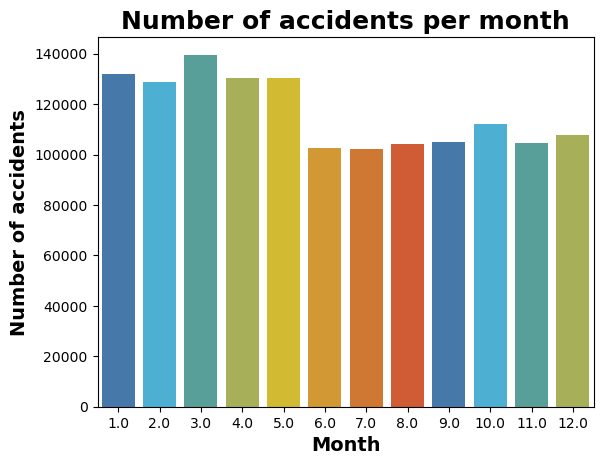

In [16]:
sns.barplot(x=df['month'], y=df['count'], palette=my_colors)

plt.title('Number of accidents per month', size=18, weight='bold')
plt.xlabel('Month', size=14, weight='bold')
plt.ylabel(f'Number of accidents', size=14, weight='bold')
plt.show()

**Analysis of the distribution of accidents by months depending on the year**

In [17]:
query = '''SELECT EXTRACT(MONTH from collision_date::date) AS month, count(*)
            FROM collisions
            WHERE EXTRACT(YEAR from collision_date::date) = 2009
            GROUP BY EXTRACT(MONTH from collision_date::date)
             '''
df_2009 = pd.read_sql_query(query, con=engine)

query = '''SELECT EXTRACT(MONTH from collision_date::date) AS month, count(*)
            FROM collisions
            WHERE EXTRACT(YEAR from collision_date::date) = 2010
            GROUP BY EXTRACT(MONTH from collision_date::date)
             '''
df_2010 = pd.read_sql_query(query, con=engine)

query = '''SELECT EXTRACT(MONTH from collision_date::date) AS month, count(*)
            FROM collisions
            WHERE EXTRACT(YEAR from collision_date::date) = 2011
            GROUP BY EXTRACT(MONTH from collision_date::date)
             '''
df_2011 = pd.read_sql_query(query, con=engine)

query = '''SELECT EXTRACT(MONTH from collision_date::date) AS month, count(*)
            FROM collisions
            WHERE EXTRACT(YEAR from collision_date::date) = 2012
            GROUP BY EXTRACT(MONTH from collision_date::date)
             '''
df_2012 = pd.read_sql_query(query, con=engine)

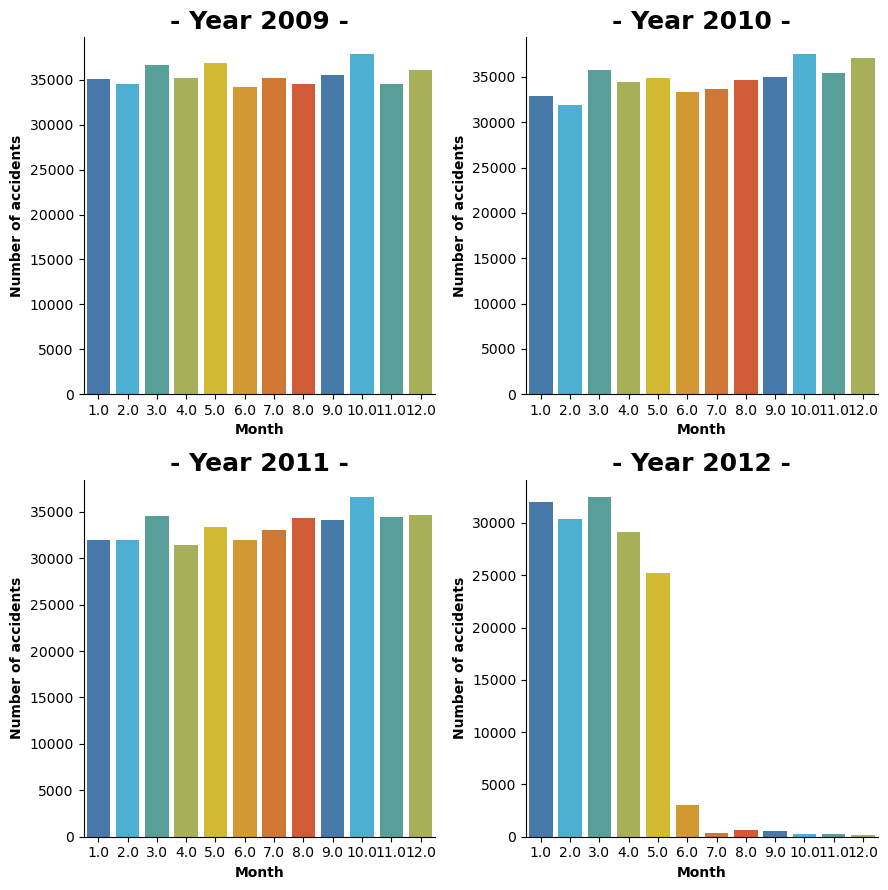

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))
titles = ['2009', '2010', '2011', '2012']

sns.barplot(x=df_2009['month'], y=df_2009['count'], ax=ax1, palette=my_colors)
sns.barplot(x=df_2010['month'], y=df_2010['count'], ax=ax2, palette=my_colors)
sns.barplot(x=df_2011['month'], y=df_2011['count'], ax=ax3, palette=my_colors)
sns.barplot(x=df_2012['month'], y=df_2012['count'], ax=ax4, palette=my_colors)

for ax, t in zip([ax1, ax2, ax3, ax4], titles):
    ax.set_title(f'- Year {t} -', size=18, weight='bold')
    ax.set_xlabel('Month', weight='bold')
    ax.set_ylabel(f'Number of accidents', weight='bold')


sns.despine()
fig.tight_layout()

**Resume**

1. Data for 2013 and 2020 were not used in the analysis due to the low number of accidents.
2. In 2009-2011, there is a uniform distribution by months. In October, the number of accidents slightly exceeds the rest.
3. In the 2012 data, there is a sharp decline in the number of accidents in the second half of the year. What this anomaly is associated with is not yet clear.

## Data preprocessing

Merge tables and upload them to a dataframe for further work

In [19]:
query = '''SELECT p.case_id, p.party_type, p.party_number, p.at_fault, p.party_sobriety, p.party_drug_physical, p.cellphone_in_use,
              c.county_city_location, c.county_location, c.distance, c.direction, c.intersection, c.weather_1, c.location_type,
              c.collision_damage, c.party_count, c.primary_collision_factor, c.pcf_violation_category, c.type_of_collision,
              c.motor_vehicle_involved_with, c.road_surface, c.road_condition_1, c.lighting, c.control_device, c.collision_date,
              c.collision_time, v.vehicle_type, v.vehicle_transmission, v.vehicle_age
       FROM parties p
       LEFT JOIN collisions c ON p.case_id = c.case_id
       LEFT JOIN vehicles v ON (v.case_id = p.case_id AND v.party_number = p.party_number)
       WHERE p.party_type = 'car'
             AND c.collision_damage <> 'scratch'
             AND EXTRACT('year' FROM c.collision_date) = 2012
'''
data_from_query = pd.read_sql_query(query, con=engine, parse_dates=['collision_date'])

In [20]:
data_from_query.head(2)

,case_id,party_type,party_number,at_fault,party_sobriety,party_drug_physical,cellphone_in_use,county_city_location,county_location,distance,...,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time,vehicle_type,vehicle_transmission,vehicle_age
0,5455556,car,2,0,had not been drinking,None,0.0,3400,sacramento,1784.0,...,other motor vehicle,dry,normal,dark with street lights,none,2012-01-05,18:30:00,None,None,NaN
1,5491000,car,5,0,impairment unknown,G,0.0,1954,los angeles,100.0,...,other motor vehicle,dry,normal,daylight,none,2012-02-02,09:30:00,None,None,NaN


In [21]:
data_from_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 29 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   case_id                      196837 non-null  object        
 1   party_type                   196837 non-null  object        
 2   party_number                 196837 non-null  int64         
 3   at_fault                     196837 non-null  int64         
 4   party_sobriety               193212 non-null  object        
 5   party_drug_physical          25148 non-null   object        
 6   cellphone_in_use             171464 non-null  float64       
 7   county_city_location         196837 non-null  object        
 8   county_location              196837 non-null  object        
 9   distance                     196837 non-null  float64       
 10  direction                    153975 non-null  object        
 11  intersection              

In [22]:
# Feature selection for model training
features = [
    'at_fault', # Target 
    'party_sobriety',
    'party_drug_physical',
    'cellphone_in_use',
    'intersection',
    'weather_1',
    'road_surface',
    'road_condition_1',
    'lighting', 
    'location_type',
    'control_device', 
    'collision_time', 
    'vehicle_type', 
    'vehicle_transmission', 
    'vehicle_age'
]

In [23]:
data = data_from_query[features]

**Resume**

- collision_damage, primary_collision_factor, pcf_violation_category, type_of_collision, motor_vehicle_involved_with, party_count are not taken into account when training the model, since these signs appear after the accident and will not help predict it

- collision_date is not taken into account, since the data is not evenly distributed over the months. Seasonal factors are taken into account in signs describing weather and road conditions

- direction, county_location, county_city_location - The influence of the direction of traffic on the accident will greatly depend on the area. It will be difficult to generalize such data into categories, especially for districts+destinations where no road accidents have yet been reported. These signs are most likely not the root cause.

### EDA

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196837 entries, 0 to 196836
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   at_fault              196837 non-null  int64  
 1   party_sobriety        193212 non-null  object 
 2   party_drug_physical   25148 non-null   object 
 3   cellphone_in_use      171464 non-null  float64
 4   intersection          195850 non-null  float64
 5   weather_1             196183 non-null  object 
 6   road_surface          195564 non-null  object 
 7   road_condition_1      195694 non-null  object 
 8   lighting              196116 non-null  object 
 9   location_type         87357 non-null   object 
 10  control_device        195864 non-null  object 
 11  collision_time        195464 non-null  object 
 12  vehicle_type          56248 non-null   object 
 13  vehicle_transmission  55389 non-null   object 
 14  vehicle_age           54554 non-null   float64
dtype

#### Target value distribution

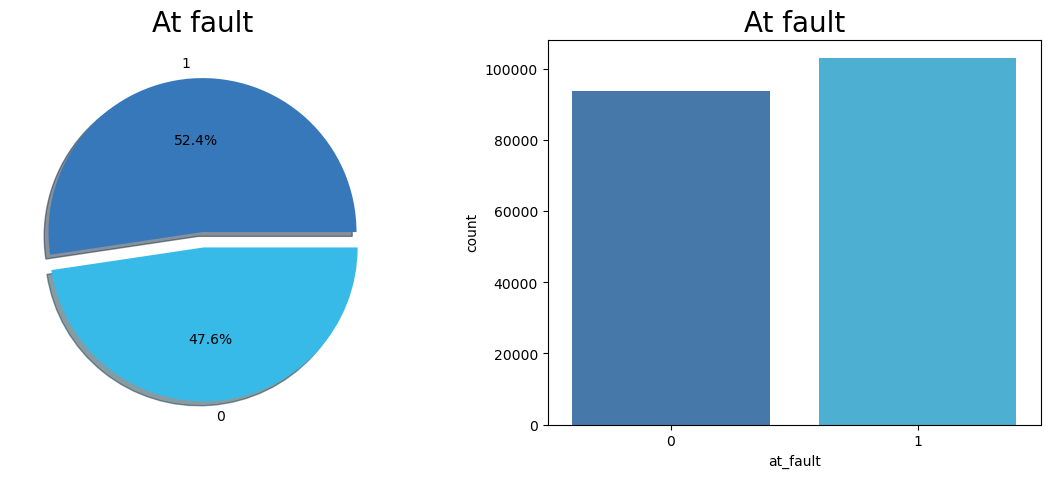

In [25]:
f,ax=plt.subplots(1,2,figsize=(14,5))
data['at_fault'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, colors=my_colors)
ax[0].set_title('At fault', size=20)
ax[0].set_ylabel('')
sns.countplot('at_fault',data=data,ax=ax[1], palette=my_colors)
ax[1].set_title('At fault',size=20)
plt.show()

**Data is balanced**

#### party_sobriety

In [26]:
data['party_sobriety'].value_counts()

had not been drinking                     157684
impairment unknown                         20525
had been drinking, under influence         10270
had been drinking, impairment unknown       1706
not applicable                              1674
had been drinking, not under influence      1353
Name: party_sobriety, dtype: int64

In [27]:
# missing values
data['party_sobriety'].isna().sum()

3625

In [28]:
# Combine the categories `impairment unknown` and `not applicable`, fill missing values with `not applicable`
data['party_sobriety'] = data['party_sobriety'].fillna('not applicable')
data['party_sobriety'] = data['party_sobriety'].mask(data['party_sobriety'] == 'impairment unknown', 'not applicable')

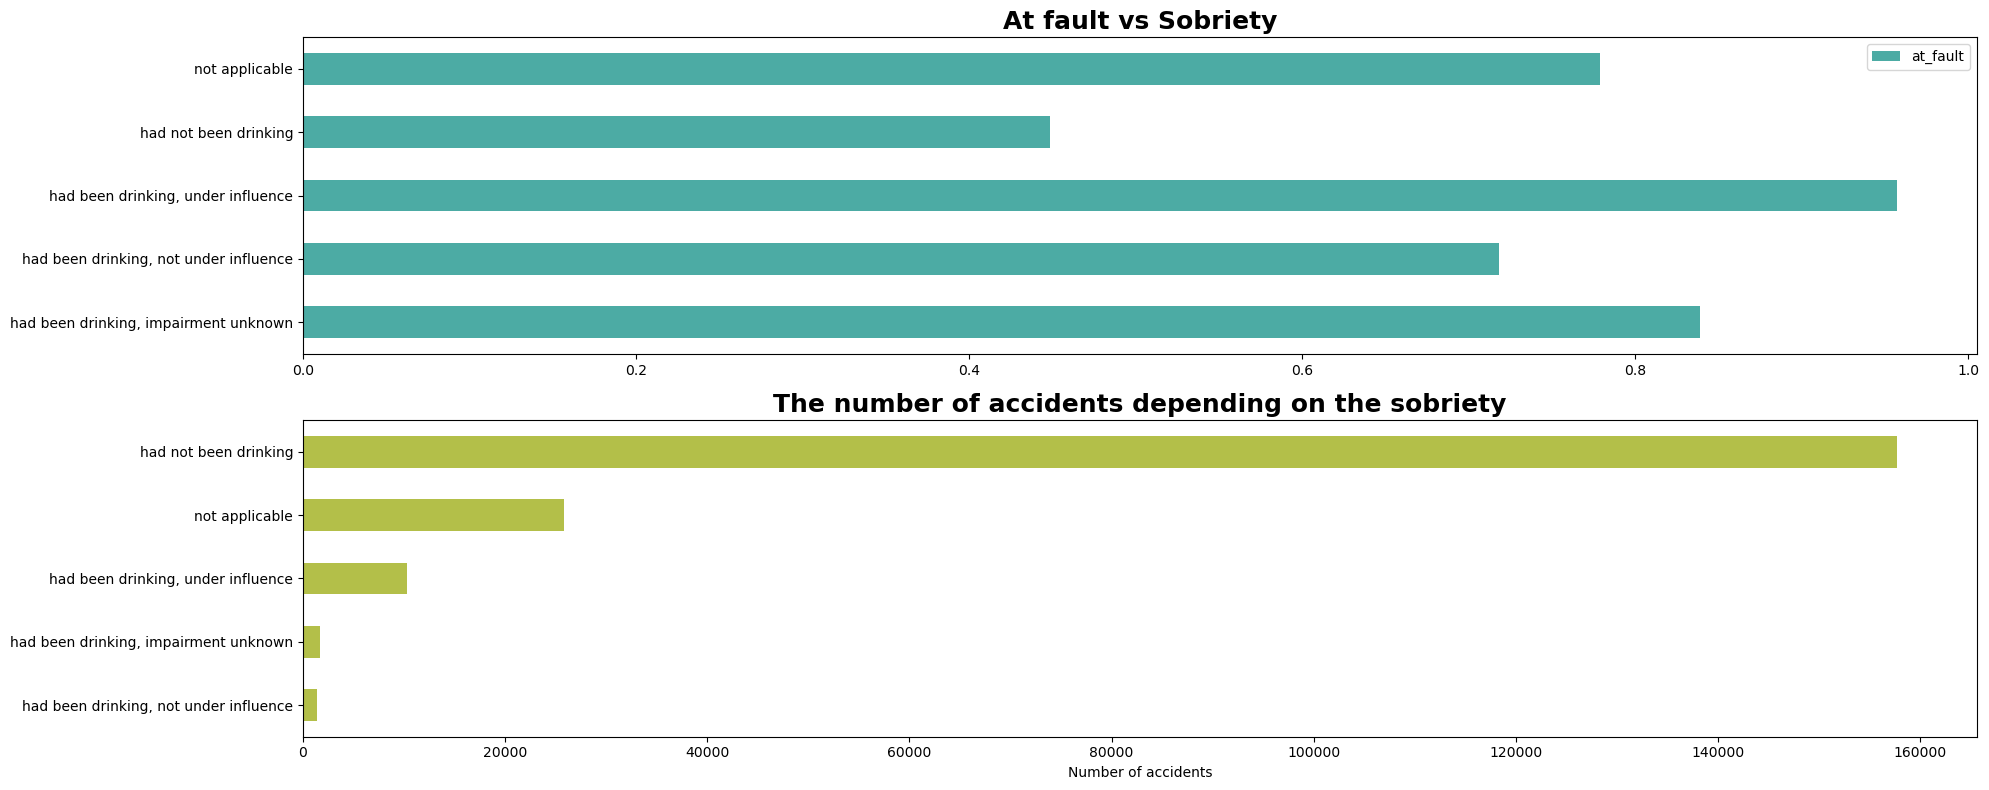

In [29]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['party_sobriety','at_fault']].groupby(['party_sobriety']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs Sobriety", size=18, weight="bold")
ax[0].set_ylabel('')



data.groupby('party_sobriety')['at_fault'].count().sort_values().plot.barh(ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('The number of accidents depending on the sobriety',size=18, weight="bold");

f.tight_layout();

Those who drank alcohol were more likely to be the culprit than those who didn't. Although sober drivers have been involved in more accidents

#### party_drug_physical

In [30]:
data['party_drug_physical'].value_counts()

G                        20525
not applicable            1674
under drug influence      1516
sleepy/fatigued           1096
impairment - physical      337
Name: party_drug_physical, dtype: int64

In [31]:
# Missing values
data['party_drug_physical'].isna().sum()

171689

In [32]:
# Combine the categories `G` and `not applicable`, fill with missing values with `not applicable`
data['party_drug_physical'] = data['party_drug_physical'].fillna('not applicable')
data['party_drug_physical'] = data['party_drug_physical'].mask(data['party_drug_physical'] == 'G', 'not applicable')

In [33]:
data['party_drug_physical'].value_counts()

not applicable           193888
under drug influence       1516
sleepy/fatigued            1096
impairment - physical       337
Name: party_drug_physical, dtype: int64

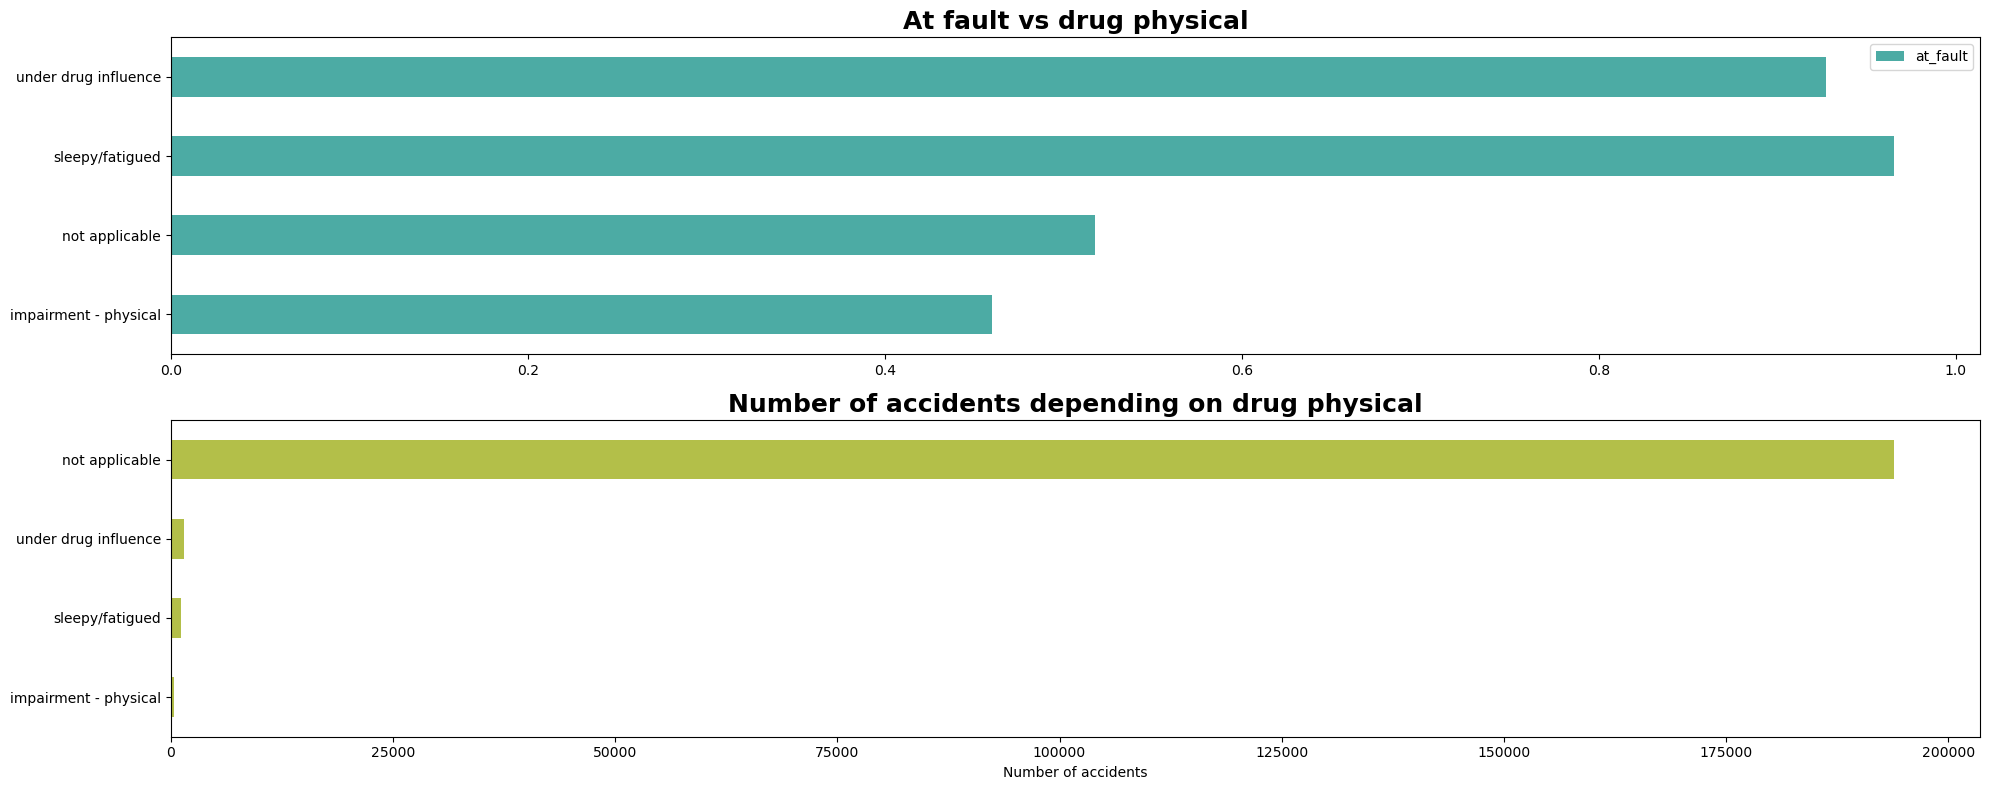

In [34]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['party_drug_physical','at_fault']].groupby(['party_drug_physical']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs drug physical", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('party_drug_physical')['at_fault'].count().sort_values().plot.barh(ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on drug physical',size=18, weight="bold")

f.tight_layout();

Those who were tired or under the influence of drugs were more likely to be at fault in road accidents than those who were physically tired.

#### cellphone_in_use

In [35]:
data['cellphone_in_use'].value_counts()

0.0    167412
1.0      4052
Name: cellphone_in_use, dtype: int64

In [36]:
data['cellphone_in_use'].isna().sum()

25373

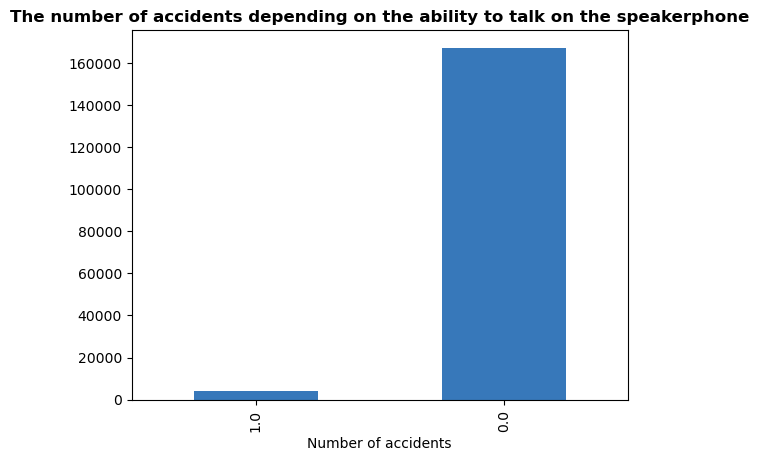

In [37]:
data.groupby('cellphone_in_use')['at_fault'].count().sort_values().plot.bar(grid=False, color=my_colors[0]);
plt.xlabel('Number of accidents')
plt.title('The number of accidents depending on the ability to talk on the speakerphone',  size=12, weight="bold")
plt.show()

Among the cars involved in the accident, the majority did not have the opportunity to talk on the speakerphone.
This feature can be excluded from further analysis.

#### weather_1

In [38]:
data['weather_1'].value_counts()

clear      157335
cloudy      29497
raining      8112
fog           584
snowing       433
other         175
wind           47
Name: weather_1, dtype: int64

In [39]:
data['weather_1'].isna().sum()

654

In [40]:
# fill missing values with 'other'
data['weather_1'] = data['weather_1'].fillna('other')

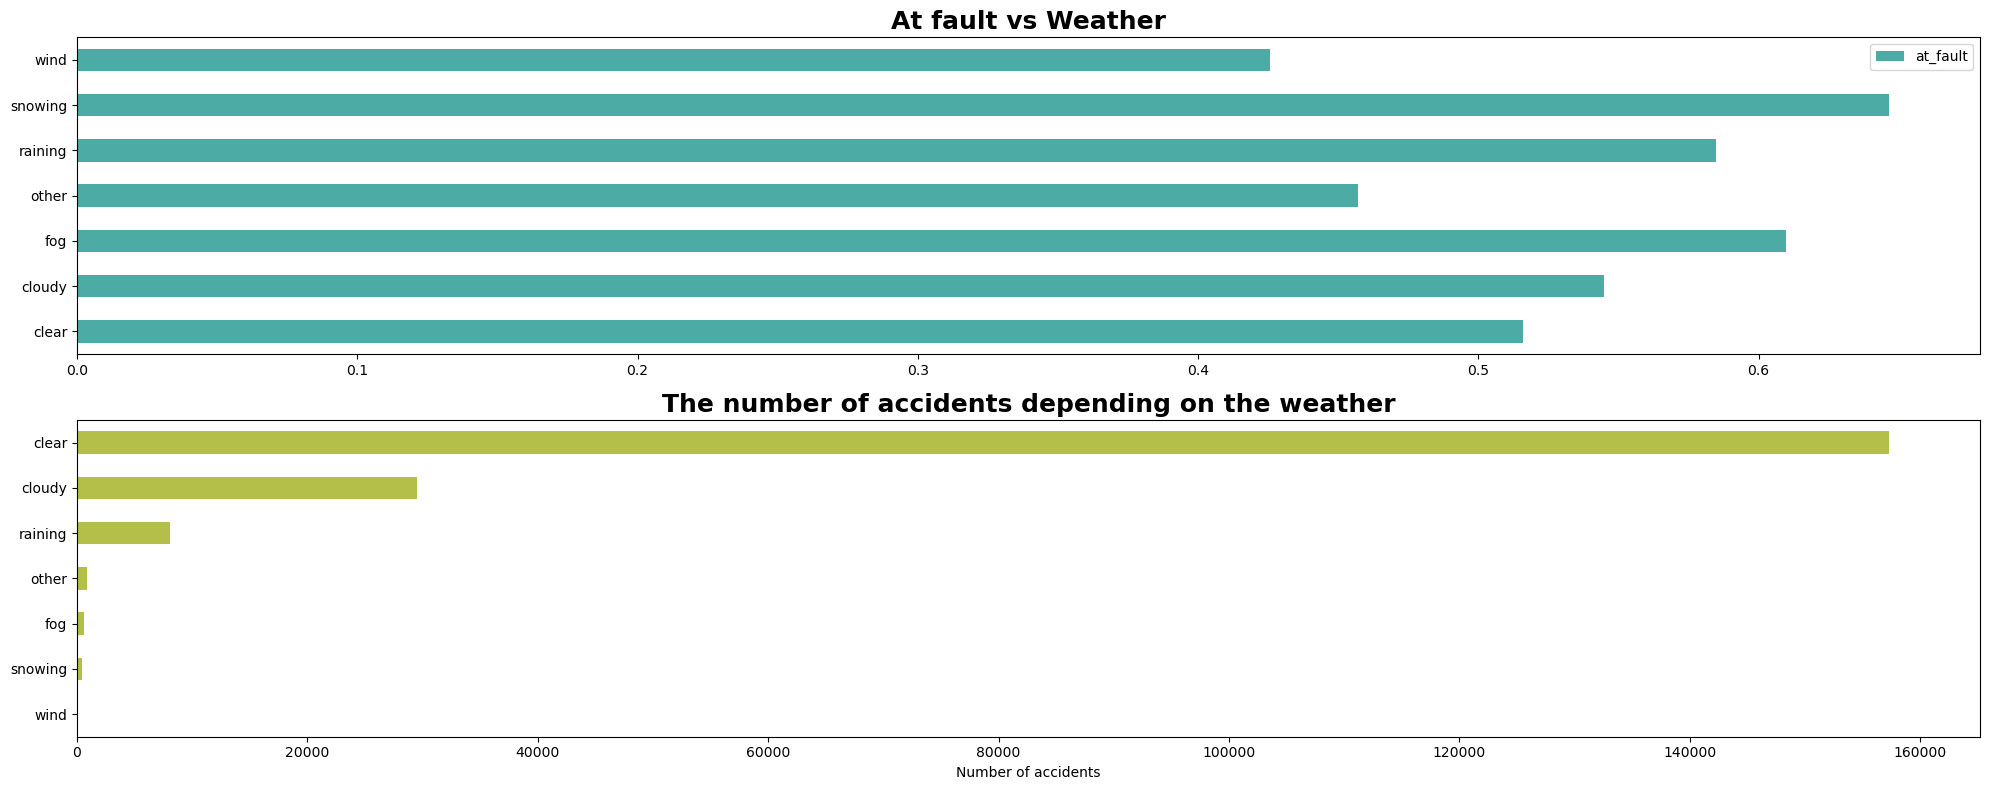

In [41]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['weather_1','at_fault']].groupby(['weather_1']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs Weather", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('weather_1')['at_fault'].count().sort_values().plot.barh(ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('The number of accidents depending on the weather',size=18, weight="bold")

f.tight_layout();

Most of those responsible for the accident were in snowy weather. Moreover, most of the accident occurred in good weather.

 #### road_surface

In [42]:
data['road_surface'].value_counts()

dry         175564
wet          18920
snowy          926
slippery       154
Name: road_surface, dtype: int64

In [43]:
data['road_surface'].isna().sum()

1273

In [44]:
data['road_surface'] = data['road_surface'].fillna('unknown')

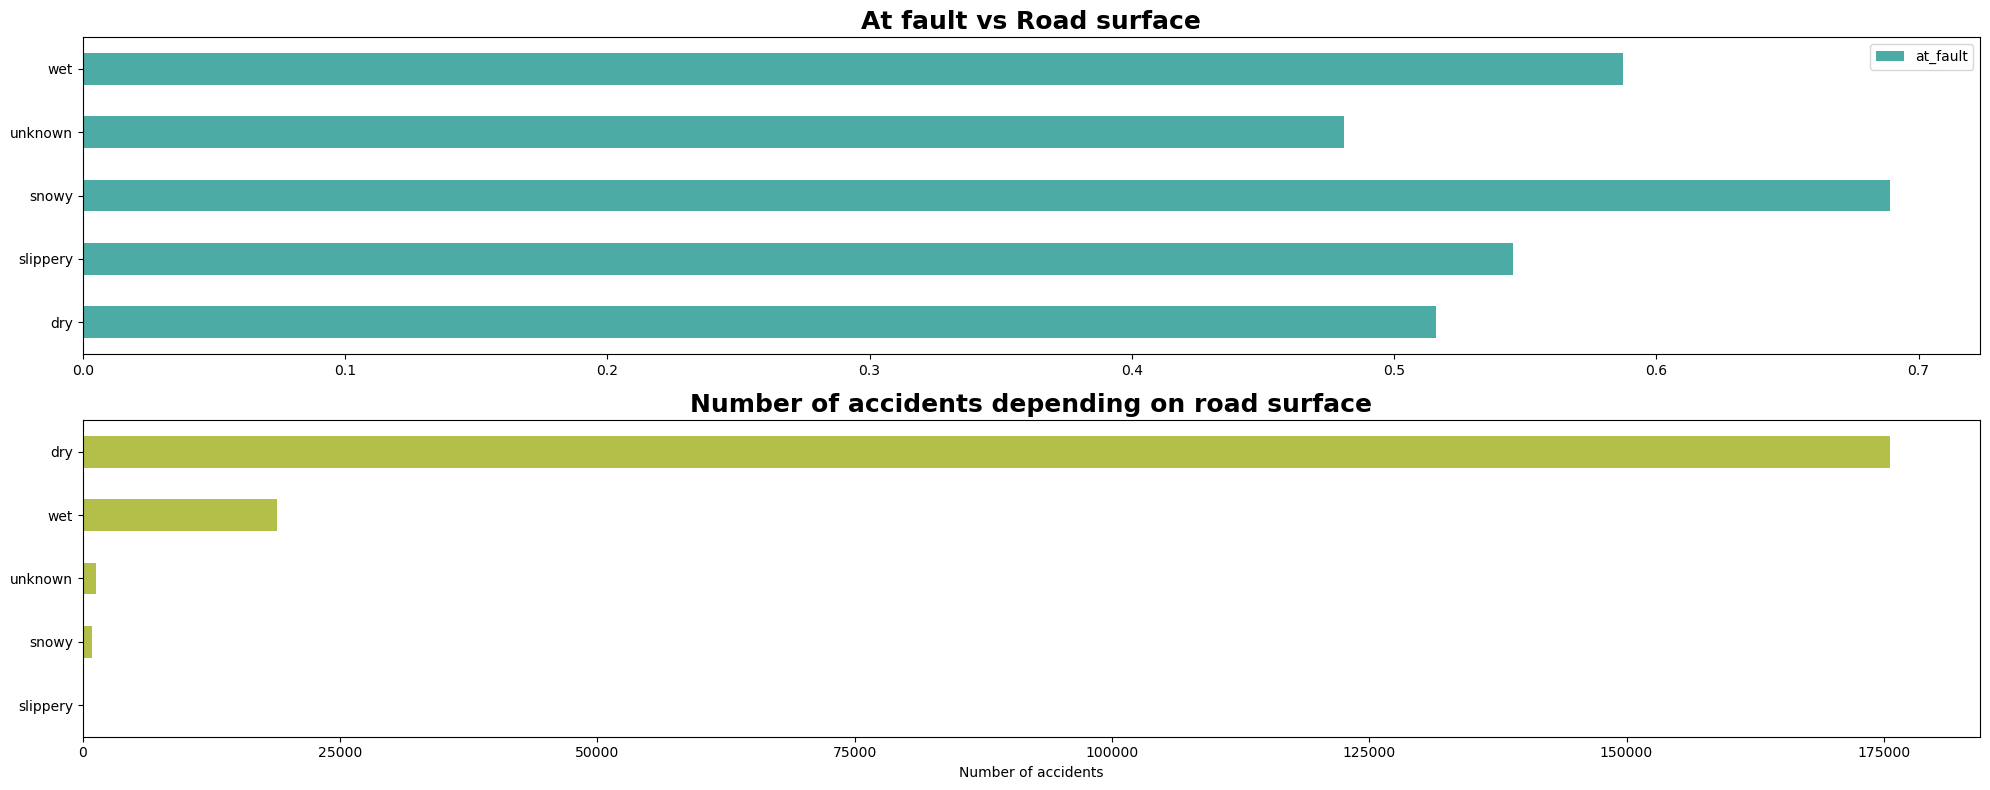

In [45]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['road_surface','at_fault']].groupby(['road_surface']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs Road surface", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('road_surface')['at_fault'].count().sort_values().plot.barh(ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on road surface',size=18, weight="bold")

f.tight_layout()

Most of the perpetrators of road accidents were during the time of roads covered with snow. At the same time, most of the accident occurred on dry roads.

#### road_condition_1

In [46]:
data['road_condition_1'].value_counts()

normal            189563
construction        3355
other                789
obstruction          729
holes                626
loose material       310
reduced width        217
flooded              105
Name: road_condition_1, dtype: int64

In [47]:
data['road_condition_1'].isna().sum()

1143

In [48]:
data['road_condition_1'] = data['road_condition_1'].fillna('other')

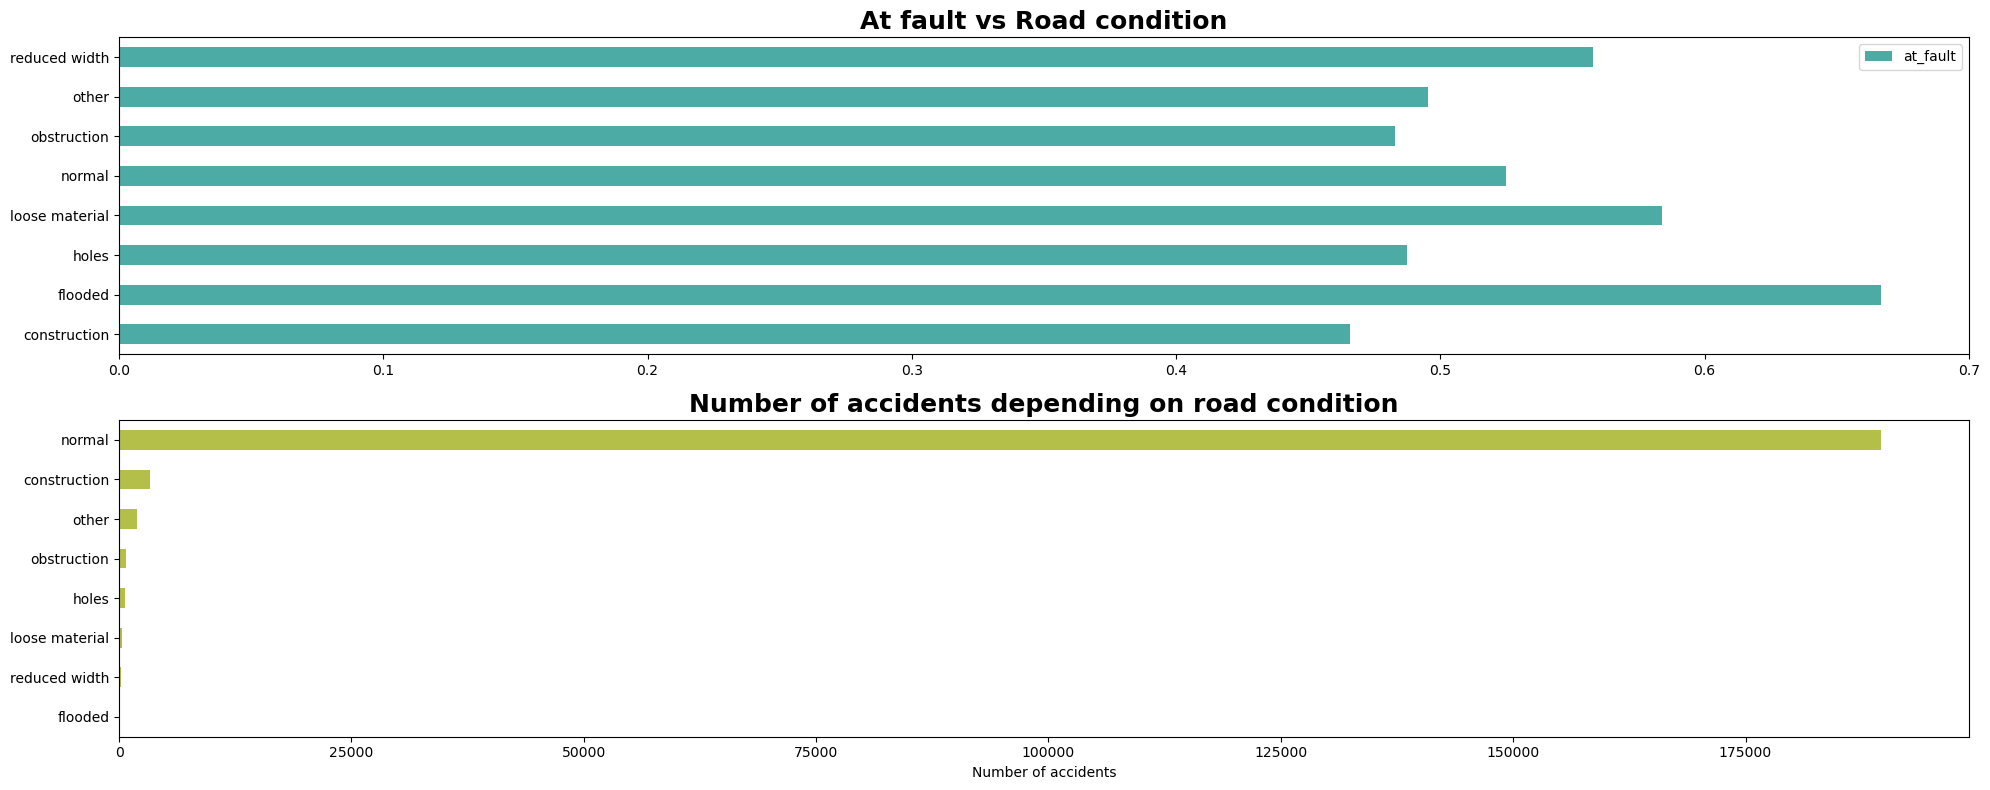

In [49]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['road_condition_1','at_fault']].groupby(['road_condition_1']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs Road condition", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('road_condition_1')['at_fault'].count().sort_values().plot.barh(ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on road condition',size=18, weight="bold")

f.tight_layout()

Drivers in the area of construction/repair work were most often guilty of road accidents. Most of the accidents happened on normal roads.

#### lighting

In [50]:
data['lighting'].value_counts()

daylight                                   136370
dark with street lights                     38095
dark with no street lights                  14430
dusk or dawn                                 6775
dark with street lights not functioning       446
Name: lighting, dtype: int64

In [51]:
data['lighting'].isna().sum()

721

In [52]:
data['lighting'] = data['lighting'].fillna('unknown')

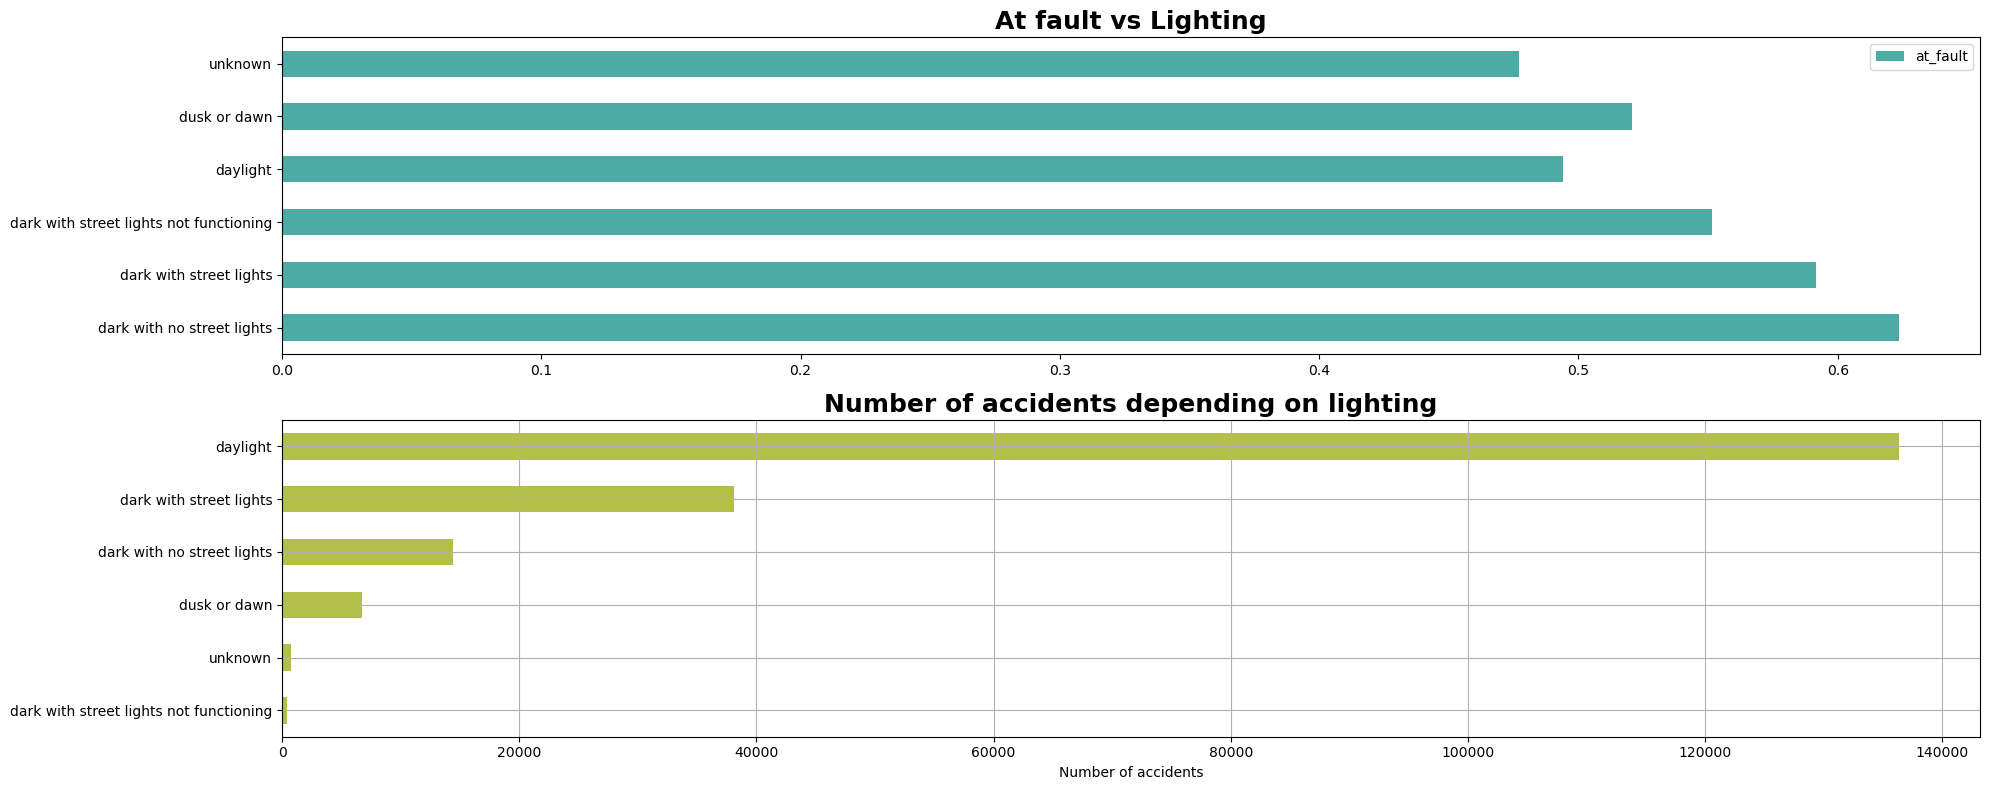

In [53]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['lighting','at_fault']].groupby(['lighting']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs Lighting", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('lighting')['at_fault'].count().sort_values().plot.barh(grid=True, ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on lighting',size=18, weight="bold")

f.tight_layout()

#### location_type

In [54]:
data['location_type'].value_counts()

highway         71914
ramp            11526
intersection     3917
Name: location_type, dtype: int64

In [55]:
data['location_type'].isna().sum()

109480

In [56]:
data['location_type'] = data['location_type'].fillna('unknown')

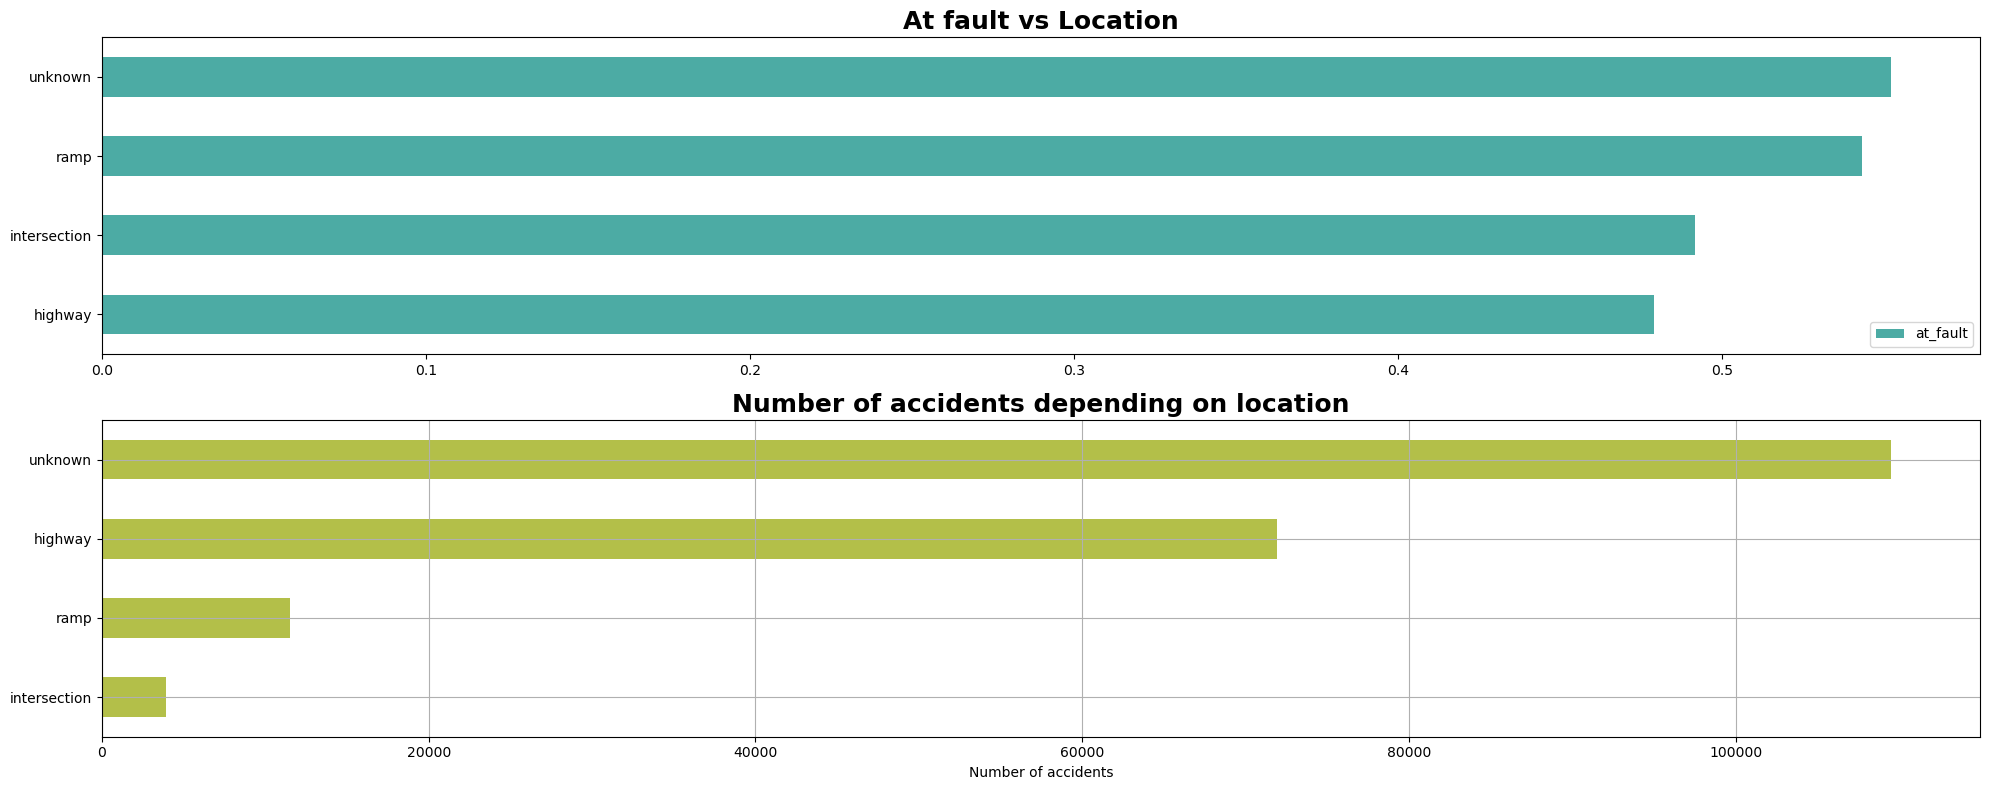

In [57]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['location_type','at_fault']].groupby(['location_type']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs Location", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('location_type')['at_fault'].count().sort_values().plot.barh(grid=True, ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on location',size=18, weight="bold")

f.tight_layout()

There were many more accidents on the highway. Thus, location_type does not predict the guilt of the driver, but affects the very fact of the incident.
This feature is not taken for further analysis.

#### control_device

In [58]:
data['control_device'].value_counts()

none               132665
functioning         62639
not functioning       444
obscured              116
Name: control_device, dtype: int64

In [59]:
data['control_device'].isna().sum()

973

In [60]:
data['control_device'] = data['control_device'].fillna('none')

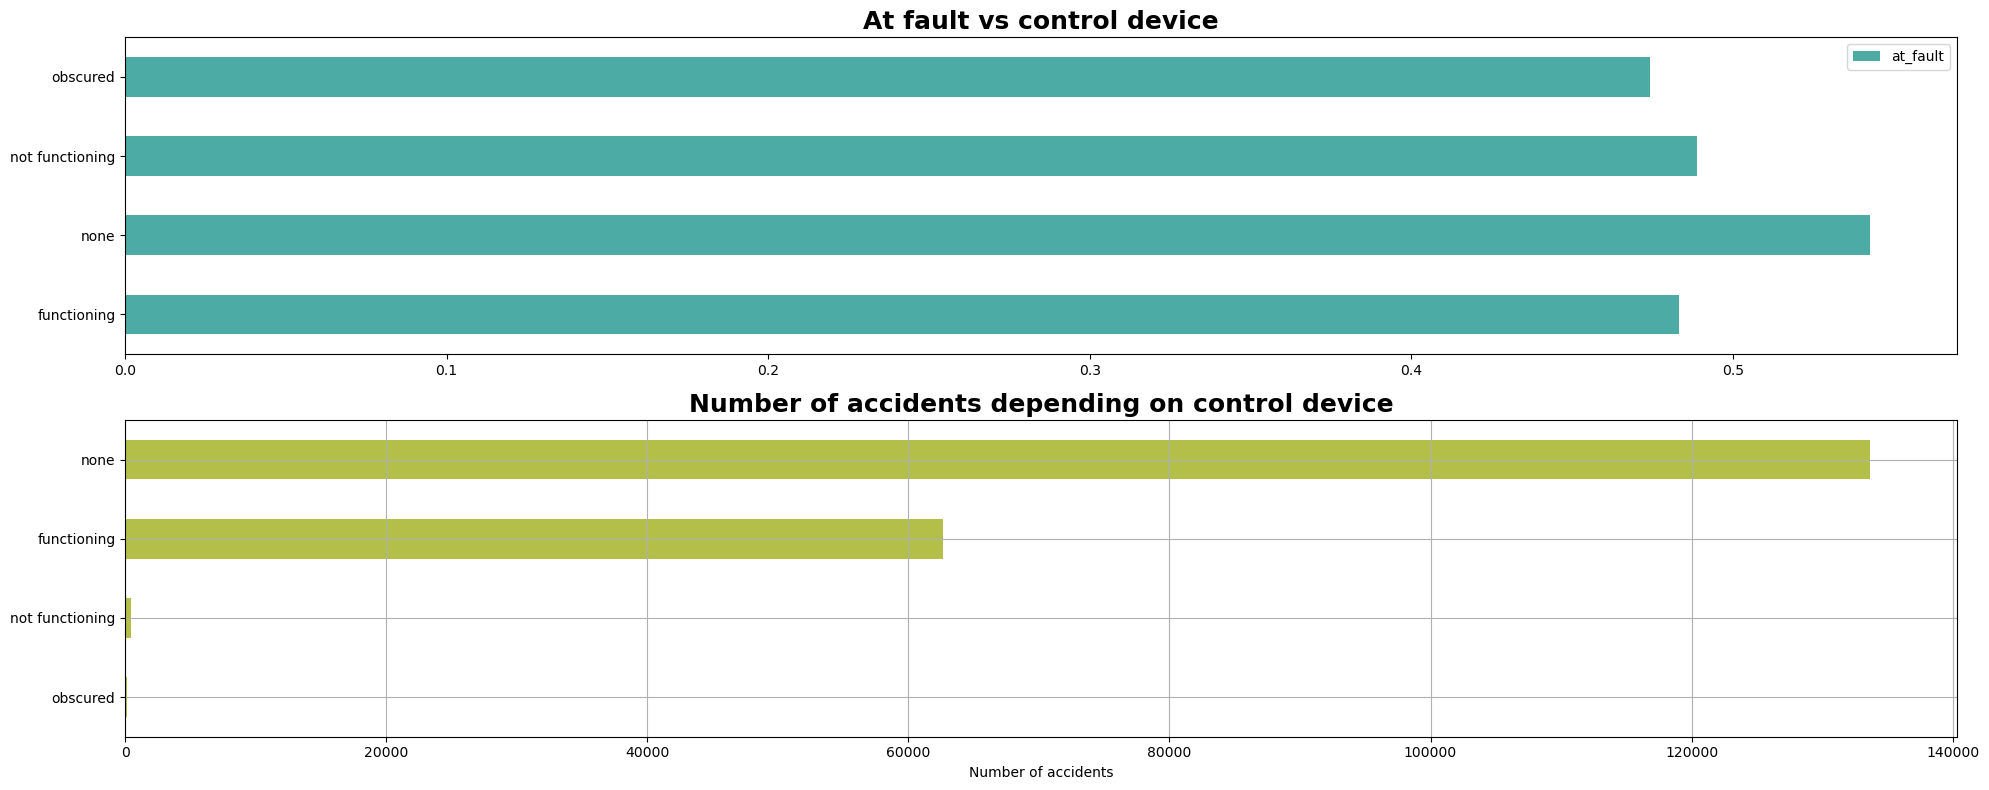

In [61]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['control_device','at_fault']].groupby(['control_device']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs control device", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('control_device')['at_fault'].count().sort_values().plot.barh(grid=True, ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on control device',size=18, weight="bold")

f.tight_layout()

The proportion of those responsible for road accidents under various control states is almost the same. This feature can be excluded from further analysis.

#### vehicle_type

In [62]:
data['vehicle_type'].value_counts()

sedan    37180
coupe    19064
other        4
Name: vehicle_type, dtype: int64

In [63]:
data['vehicle_type'].isna().sum()

140589

In [64]:
data['vehicle_type'] = data['vehicle_type'].fillna('other')

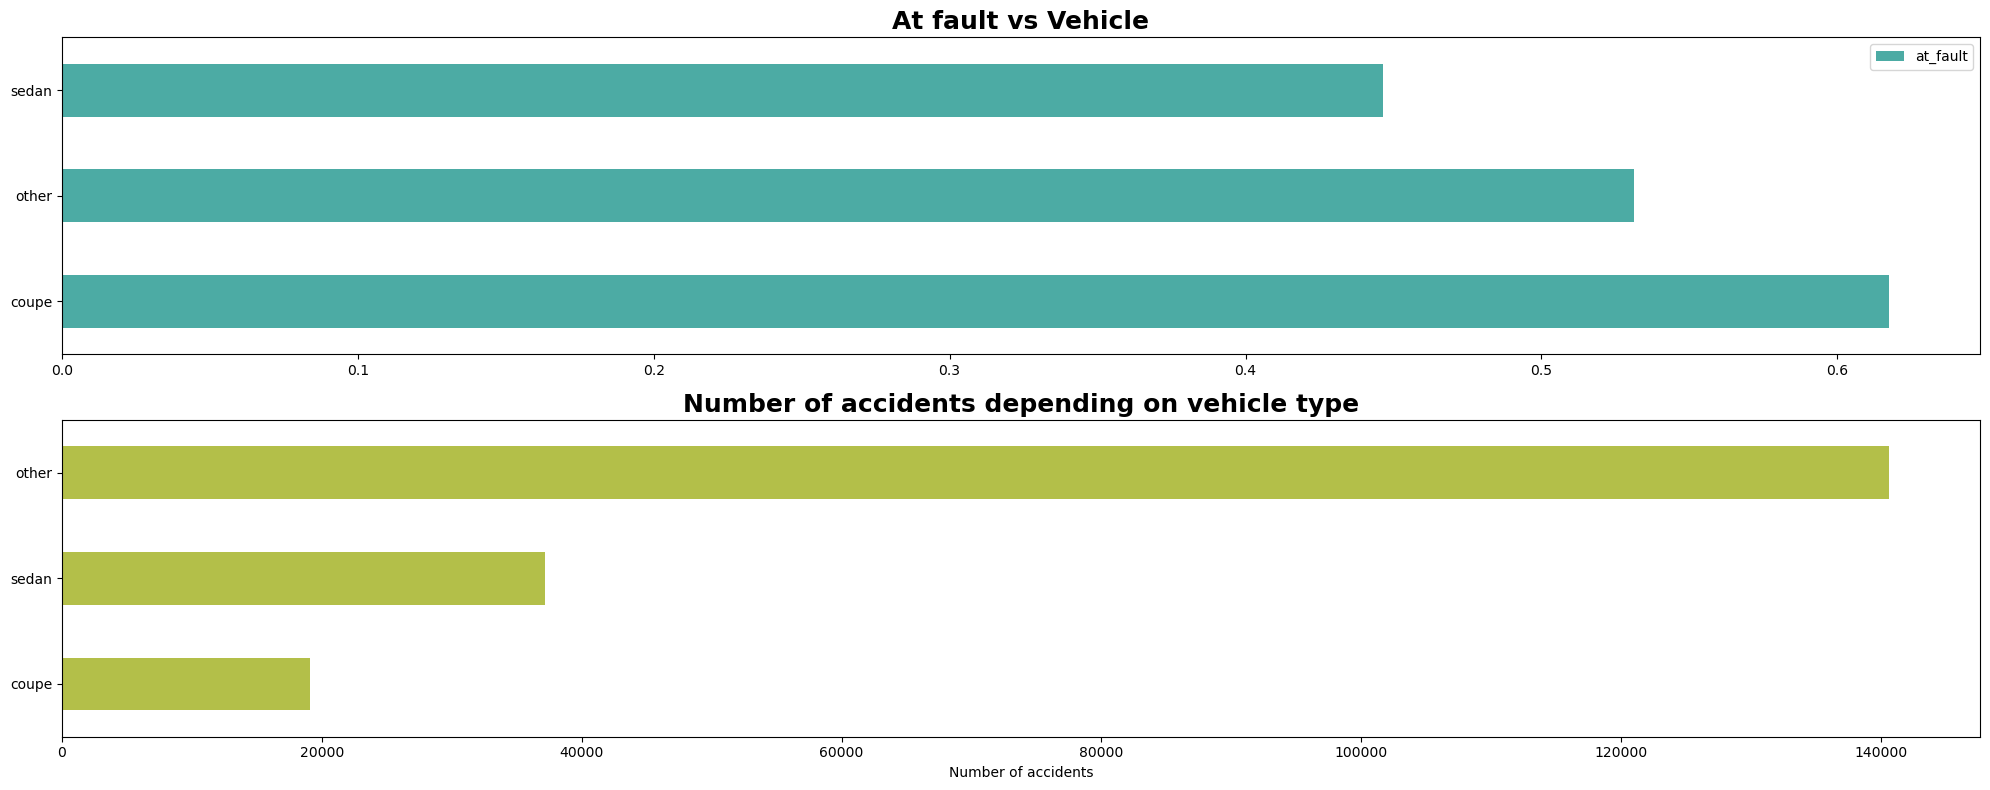

In [65]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['vehicle_type','at_fault']].groupby(['vehicle_type']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs Vehicle", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('vehicle_type')['at_fault'].count().sort_values().plot.barh(ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on vehicle type',size=18, weight="bold")

f.tight_layout()

Most often, the culprits of the accidents were drivers of coupe cars. Most of the accidents were in cars of the "sedan" type.

#### vechicle_transmission

In [66]:
data['vehicle_transmission'].value_counts()

manual    29318
auto      26071
Name: vehicle_transmission, dtype: int64

In [67]:
data['vehicle_transmission'].isna().sum()

141448

Most of the data is missing. This feature can be excluded from further analysis.


#### intersection

In [68]:
data['intersection'].value_counts()

0.0    156308
1.0     39542
Name: intersection, dtype: int64

In [69]:
data['intersection'].isna().sum()

987

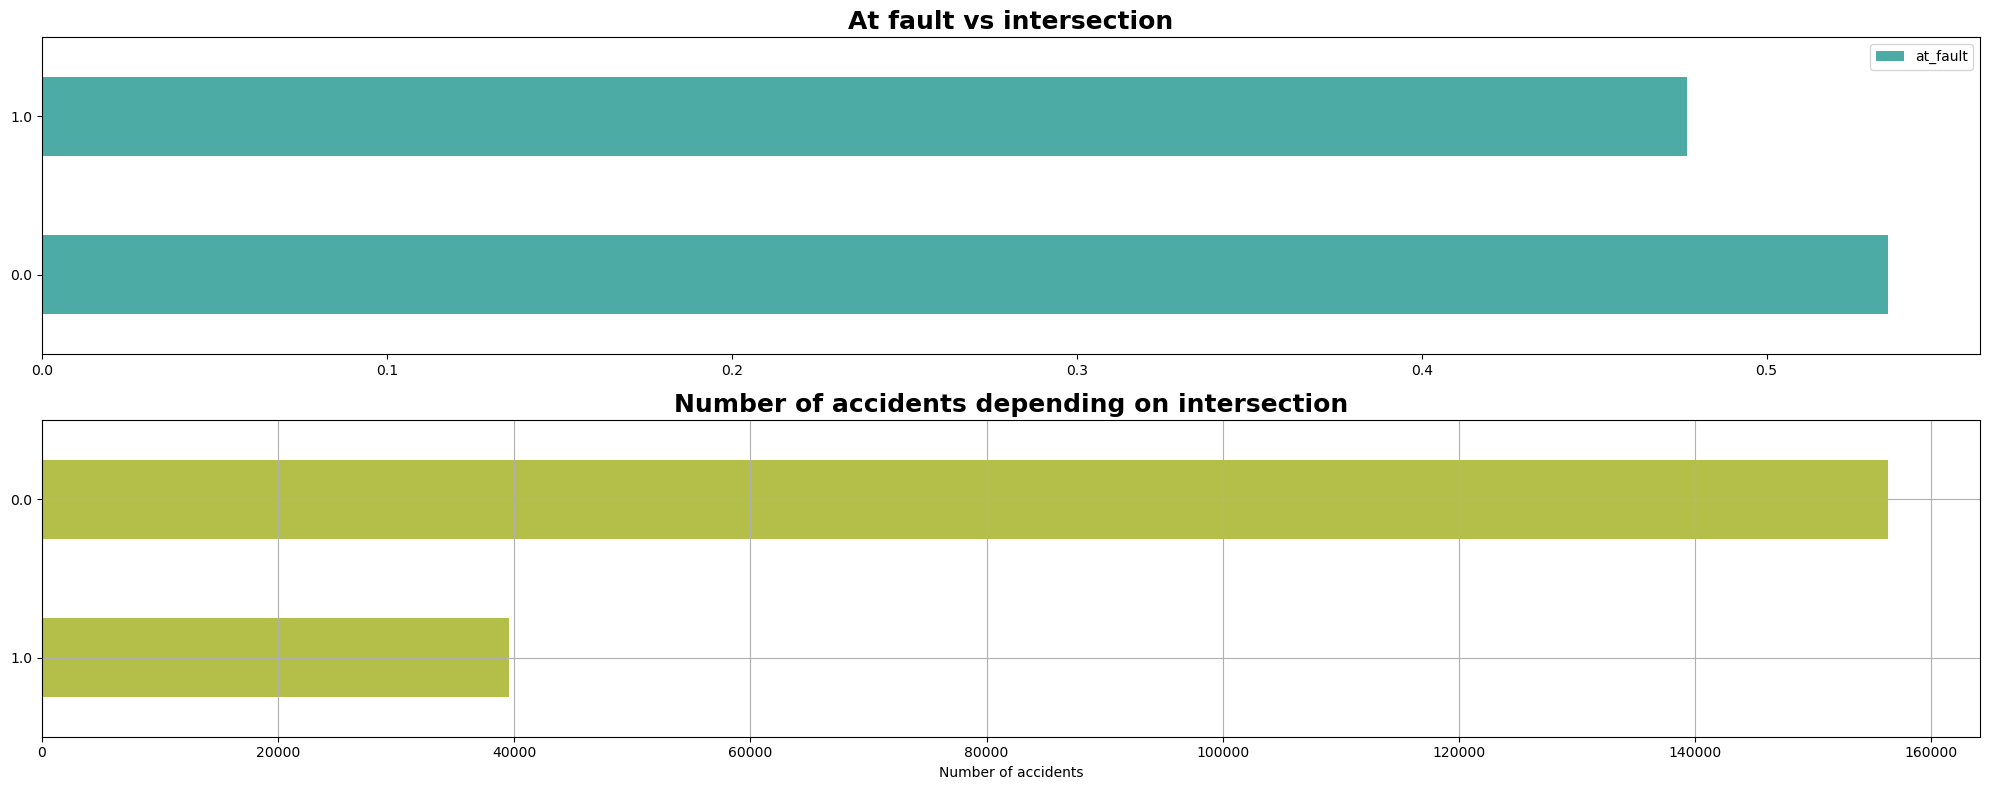

In [70]:
f,ax=plt.subplots(2, 1, figsize=(20,8))

data[['intersection','at_fault']].groupby(['intersection']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs intersection", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('intersection')['at_fault'].count().sort_values().plot.barh(grid=True, ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on intersection',size=18, weight="bold")

f.tight_layout()

Most accidents do not occur at intersections. At the same time, the share of perpetrators in road accidents that occurred at the intersection and outside it is practically the same.
This feature can be excluded from further analysis.

#### collision_time

In [71]:
def extract_hour(datetime_value):
    try:
        hour = [datetime_value.hour if datetime_value.minute <= 30 else datetime_value.hour + 1][0]
        return hour
    except:
        return np.nan

In [72]:
data['collision_time'] = data['collision_time'].apply(extract_hour)

In [73]:
data['collision_time'].value_counts()

15.0    15275
16.0    15035
17.0    15015
18.0    14742
8.0     13735
14.0    11777
13.0    11556
12.0    10491
19.0     9813
9.0      9779
11.0     8696
10.0     8523
7.0      7642
20.0     7025
21.0     6157
22.0     5205
23.0     4383
6.0      4179
2.0      3576
1.0      3021
3.0      2538
5.0      2065
0.0      1839
4.0      1805
24.0     1592
Name: collision_time, dtype: int64

In [74]:
data['collision_time'] = data['collision_time'].mask(data['collision_time'] == 24.0, 0.0)
data['collision_time'] = data['collision_time'].fillna(-1)

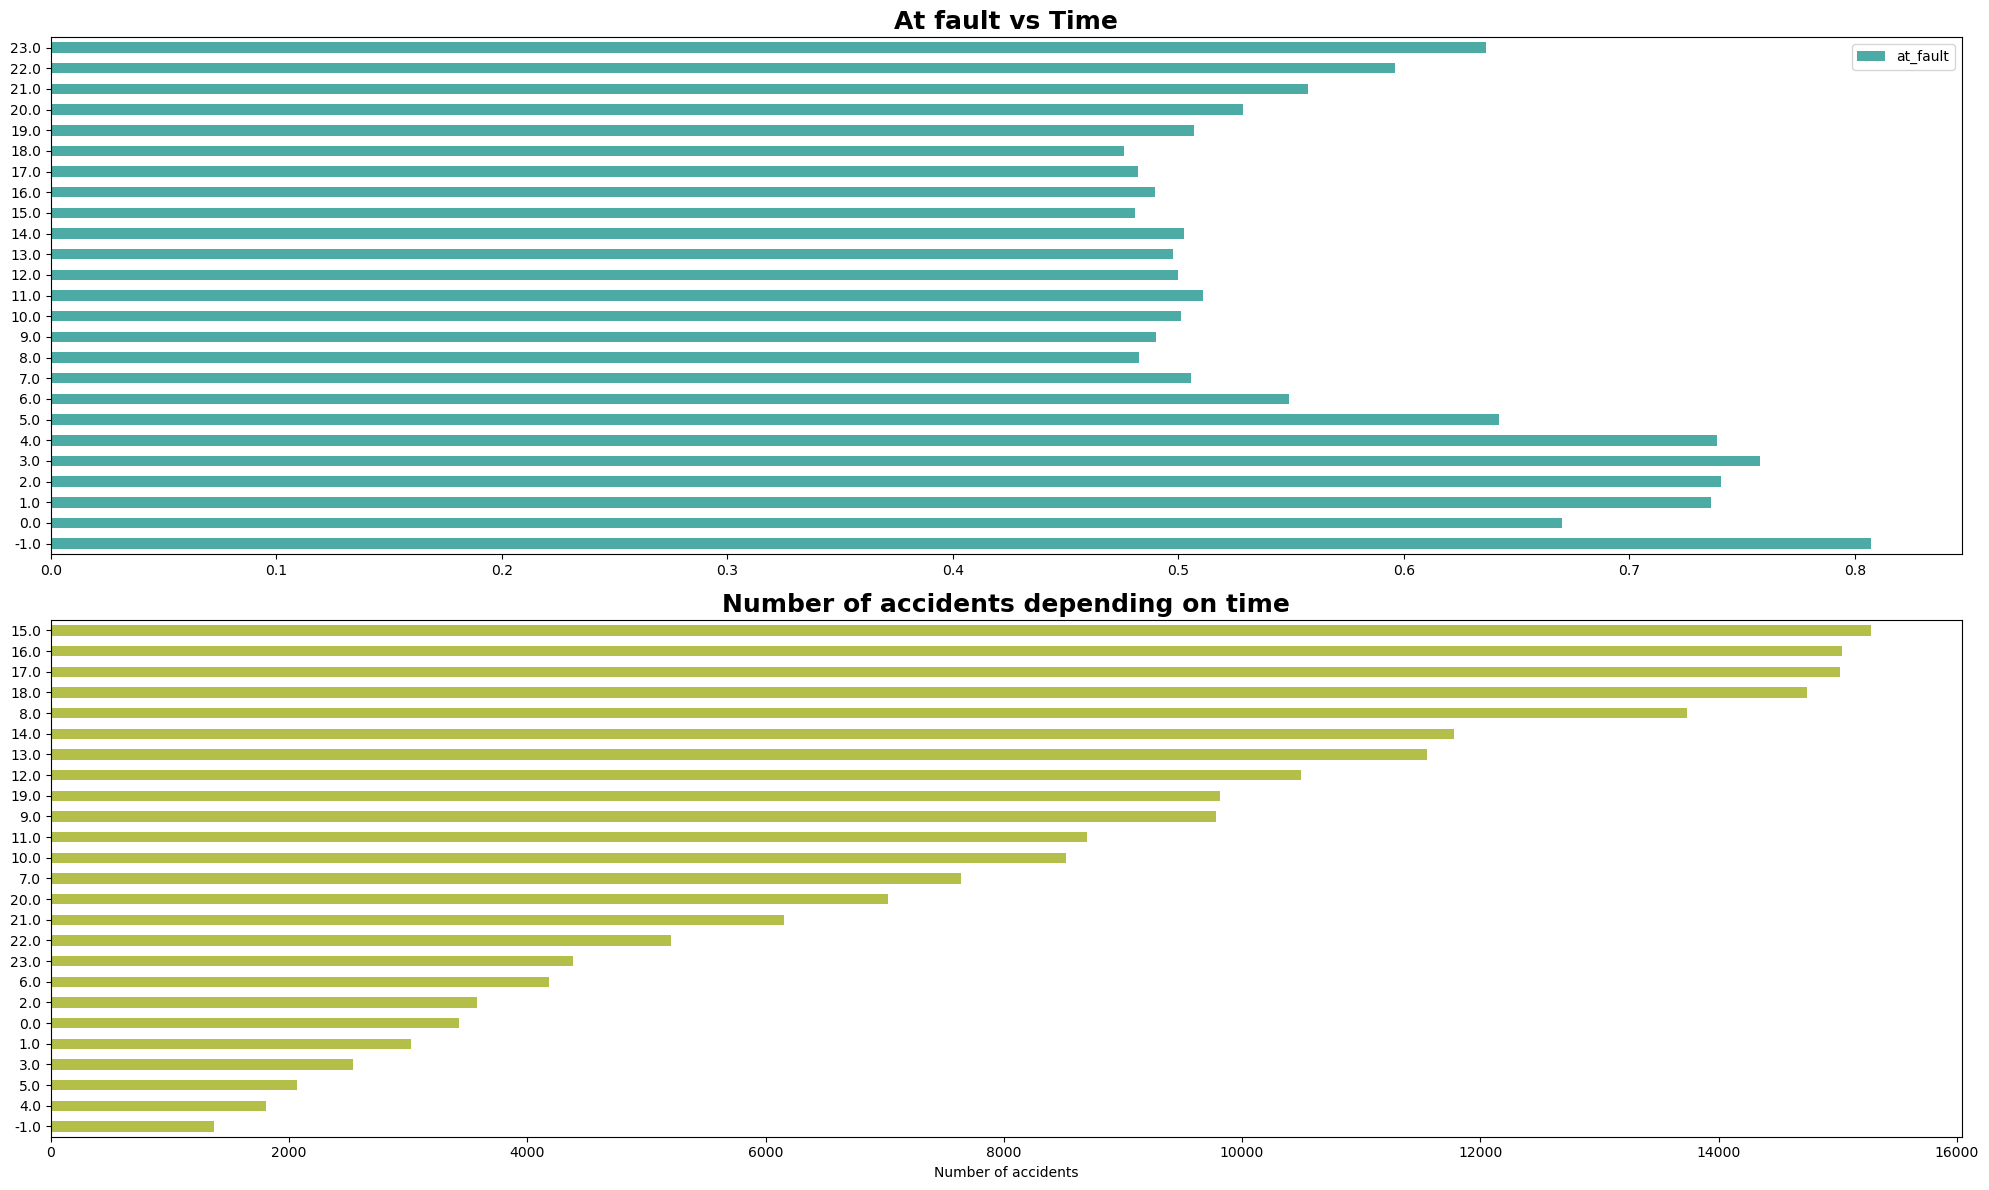

In [75]:
f,ax=plt.subplots(2, 1, figsize=(20,12))

data[['collision_time','at_fault']].groupby(['collision_time']).mean().plot.barh(ax=ax[0], color=my_colors[2])
ax[0].set_title("At fault vs Time", size=18, weight="bold")
ax[0].set_ylabel('')

data.groupby('collision_time')['at_fault'].count().sort_values().plot.barh(ax=ax[1], color=my_colors[3])
ax[1].set_xlabel('Number of accidents')
ax[1].set_ylabel('')
ax[1].set_title('Number of accidents depending on time',size=18, weight="bold")

f.tight_layout()

Most of the accidents occurred from 15:00 to 18:00, however, drivers who were driving at night were most often guilty of accidents

#### vehicle_age

In [76]:
data['vehicle_age'].describe()

count    54554.000000
mean         4.856472
std          3.234503
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

In [77]:
data['vehicle_age'].isna().sum()

142283

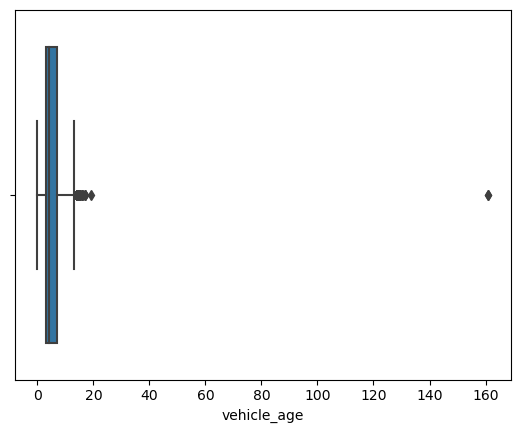

In [78]:
sns.boxplot(x="vehicle_age", data=data)
plt.show()

In [79]:
data['vehicle_age'] = data['vehicle_age'].fillna(-1)

In [80]:
data['vehicle_age'] = data['vehicle_age'].mask(data['vehicle_age'] > 20, -1)

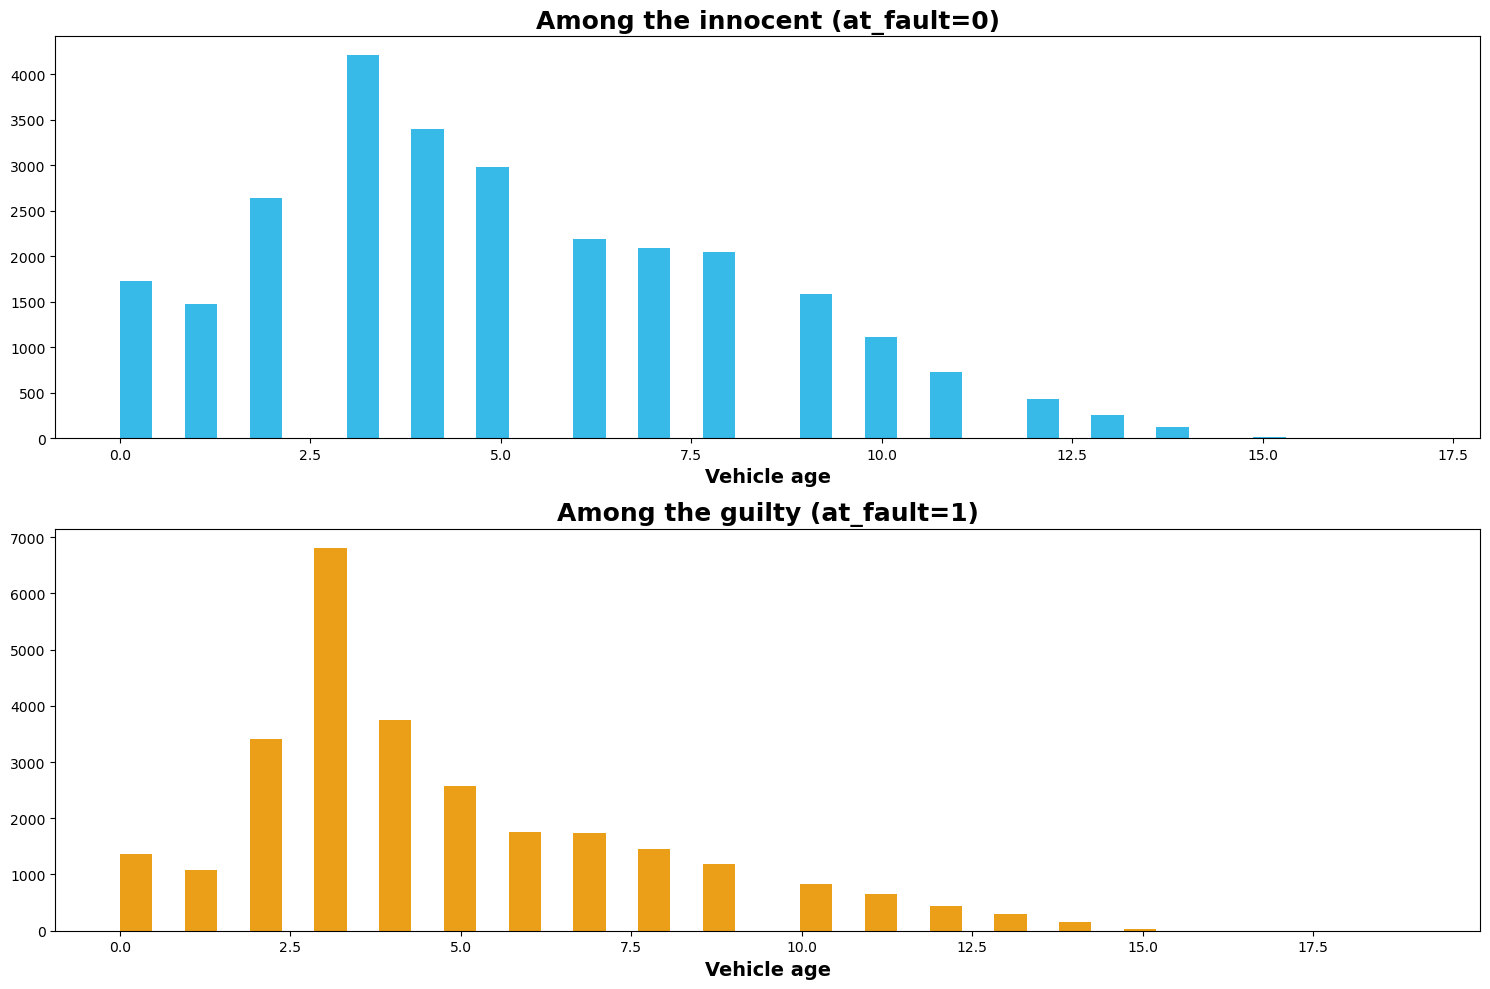

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

ax[0].hist(data[(data['at_fault'] == 0) & (data['vehicle_age'] >= 0)]['vehicle_age'], bins=40, color=my_colors[1])
ax[0].set_title('Among the innocent (at_fault=0)', size=18, weight="bold")
ax[0].set_xlabel('Vehicle age', size=14, weight="bold")


ax[1].hist(data[(data['at_fault'] == 1) & (data['vehicle_age'] >= 0)]['vehicle_age'], bins=40, color=my_colors[5])
ax[1].set_title('Among the guilty (at_fault=1)', size=18, weight="bold")
ax[1].set_xlabel('Vehicle age', size=14, weight="bold")

fig.tight_layout()

Most of the perpetrators of the accident drove cars aged 2-5 years

interval columns not set, guessing: ['at_fault', 'cellphone_in_use', 'intersection', 'collision_time', 'vehicle_age']


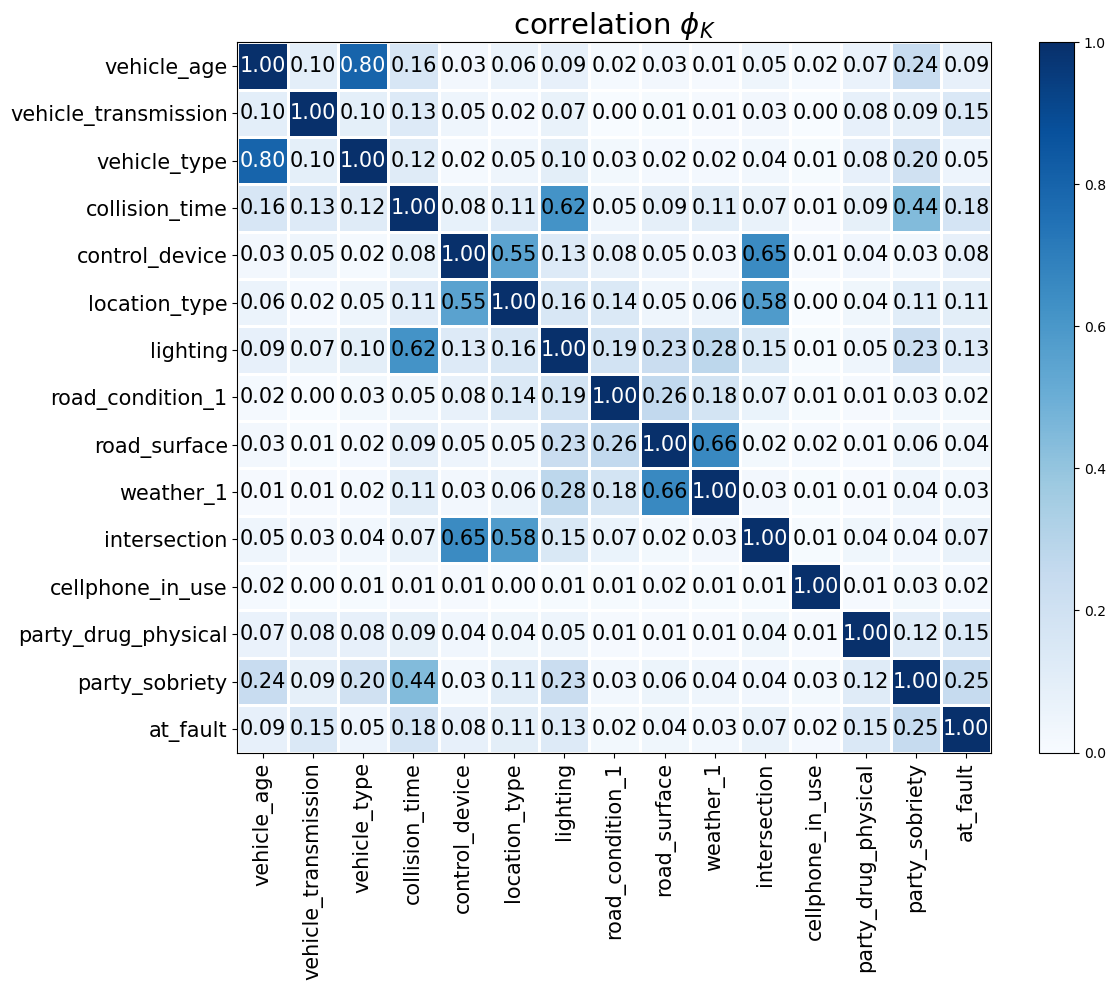

In [82]:
phik_overview = data.phik_matrix()
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(12, 10))
plt.tight_layout()

There is a high correlation between some features:
- vehicle_age и vehicle_type
- lighting и collision_time
- intersection и control_device
The at_fault target value has the most pronounced correlation with the party_sobriety feature

### Data for model training

In [83]:
final_features = [ 
'party_sobriety', 
'party_drug_physical',
'weather_1', 
'road_surface', 
'road_condition_1',
'lighting',
'collision_time',
'vehicle_type',
'vehicle_age'
]

In [84]:
X = data[final_features]
y = data['at_fault']


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [86]:
numeric = ['vehicle_age', 'collision_time']
categorical = ['party_sobriety', 'party_drug_physical', 'weather_1', 'road_surface', 'road_condition_1', 'lighting', 'vehicle_type']

In [87]:
col_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numeric),
        ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
    remainder="passthrough"
)

In [88]:
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

In [89]:
X_train.shape, X_test.shape

((137785, 33), (59052, 33))

## Model train

1. Take as models:
     - Random Forest Classifier
     - AdaBoostClassifier
     - Cat Boost Classifier
+ Select hyperparameters
+ Carry out cross-validation of models
2. Compare the resulting models by metrics:
     - precision
     - Recall
     - F1 score

Recall is the most significant indicator, since it is important for us to identify all possible accidents, even at the cost of false warnings. Potentially, it will be cheaper for the client to warn the driver in advance and very expensive if an accident occurs.
However, the F1-score metric should also be monitored in order to strike a balance between accuracy and completeness. It may not be profitable for the client to spend resources on too many False Positive results.

### Hyperparameter tuning

In [90]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

#### RandomForestClassifier

In [91]:
rf = RandomForestClassifier(random_state=42)
rf_parameters = {'n_estimators': [10, 50, 100],
                 'max_depth': [3, 5, 10],
                 'min_samples_leaf': [3, 5, 7],
                 'min_samples_split': [2, 3]}

rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_parameters, n_jobs=-1, cv=kf, scoring='f1')

# storing the values
rf_grid_result = rf_grid_search.fit(X_train, y_train)
# printing the best parameters
print("F1-score for RandomForestClassifier: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))

F1-score for RandomForestClassifier: 0.533174 using {'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 10}


#### AdaBoost Classifier

In [92]:
abc = AdaBoostClassifier(random_state=42)
abc_parameters = {'n_estimators': [10, 50, 100],
                  'learning_rate': [0.01, 0.03, 0.1]}

abc_grid_search = GridSearchCV(estimator=abc, param_grid=abc_parameters, scoring='f1', n_jobs=-1, cv=kf)

abc_grid_result =abc_grid_search.fit(X_train, y_train)

print("F1-score for ABClassifier: %f using %s" % (abc_grid_result.best_score_, abc_grid_result.best_params_))


F1-score for ABClassifier: 0.502450 using {'learning_rate': 0.1, 'n_estimators': 100}


#### CatBoostClassifier

In [93]:
cbc = CatBoostClassifier(random_state=42, auto_class_weights='Balanced')
cbc_parameters = {'n_estimators': [10, 50, 100],
                  'learning_rate': [0.03, 0.1],
                  'depth': [4, 6, 10],
                  'l2_leaf_reg': [1, 3, 5,]}

cbc_grid_search = GridSearchCV(estimator=cbc, param_grid=cbc_parameters, n_jobs=-1, cv=kf, scoring='f1')

# storing the values
cbc_grid_result = cbc_grid_search.fit(X_train, y_train)
# printing the best parameters
print("F1-score for CatBoostClassifier: %f using %s" % (cbc_grid_result.best_score_, cbc_grid_result.best_params_))

0:	learn: 0.6799990	total: 153ms	remaining: 15.2s
1:	learn: 0.6693930	total: 165ms	remaining: 8.1s
2:	learn: 0.6606508	total: 185ms	remaining: 5.97s
3:	learn: 0.6552389	total: 195ms	remaining: 4.67s
4:	learn: 0.6500150	total: 212ms	remaining: 4.02s
5:	learn: 0.6457538	total: 228ms	remaining: 3.58s
6:	learn: 0.6424054	total: 245ms	remaining: 3.25s
7:	learn: 0.6395878	total: 262ms	remaining: 3.01s
8:	learn: 0.6373877	total: 282ms	remaining: 2.85s
9:	learn: 0.6357603	total: 299ms	remaining: 2.69s
10:	learn: 0.6347703	total: 307ms	remaining: 2.49s
11:	learn: 0.6334781	total: 325ms	remaining: 2.38s
12:	learn: 0.6324829	total: 334ms	remaining: 2.24s
13:	learn: 0.6314885	total: 352ms	remaining: 2.16s
14:	learn: 0.6304613	total: 373ms	remaining: 2.11s
15:	learn: 0.6297393	total: 395ms	remaining: 2.07s
16:	learn: 0.6290540	total: 416ms	remaining: 2.03s
17:	learn: 0.6284514	total: 437ms	remaining: 1.99s
18:	learn: 0.6278978	total: 459ms	remaining: 1.96s
19:	learn: 0.6274643	total: 480ms	remainin

### Model cross-validation

In [94]:
rf = rf_grid_search.best_estimator_

abc = abc_grid_search.best_estimator_

cbc = cbc_grid_search.best_estimator_


In [95]:
scoring = ['precision', 'recall', 'f1']
score = {}
def cv_model(model, X=X):

    result = cross_validate(model, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1)

    return (result)

In [96]:
result = cv_model(rf)
score['rf'] = (result['test_precision'].mean(),
               result['test_recall'].mean(),
               result['test_f1'].mean())

In [97]:
result = cv_model(abc)
score['abc'] = (result['test_precision'].mean(),
                result['test_recall'].mean(),
                result['test_f1'].mean())

In [98]:
result = cv_model(cbc)
score['cbc'] = (result['test_precision'].mean(),
                result['test_recall'].mean(),
                result['test_f1'].mean())

In [99]:
index = list(score.keys())
df = {'Precision':[score.get('rf')[0],
                   score.get('abc')[0],
                   score.get('cbc')[0]],
      'Recall':[score.get('rf')[1],
                score.get('abc')[1],
                score.get('cbc')[1]],
      'F1-score':[score.get('rf')[2],
                  score.get('abc')[2],
                  score.get('cbc')[2]]}

scores_data = pd.DataFrame(data=df, index=index)

scores_data

,Precision,Recall,F1-score
rf,0.750472,0.413651,0.533174
abc,0.778083,0.371077,0.502450
cbc,0.762738,0.404170,0.528355


For further analysis, take the AdaBoost Classifier model.

From a business point of view, the completeness metric is the most relevant, since it is necessary to prevent the largest number of accidents and better play it safe and get more false positive results.

### Test best model

In [100]:
abc.fit(X_train, y_train)
pred = abc.predict(X_test)

print('F1 Score', f1_score(y_test, pred))
print('Precision', precision_score(y_test, pred))
print('Recall', recall_score(y_test, pred))

F1 Score 0.5046111014442318
Precision 0.7702523240371846
Recall 0.37521024712123174


In [101]:
abc_matrix = confusion_matrix(y_test, pred)

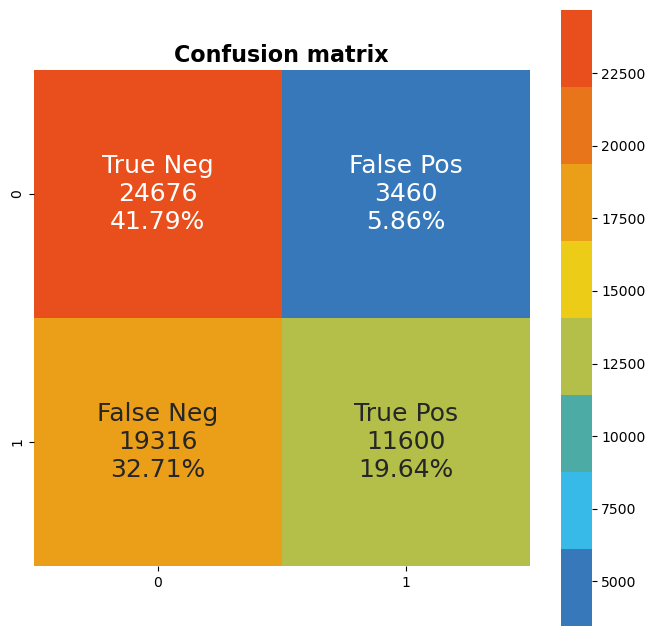

In [102]:
fig = plt.figure(figsize=(8, 8))

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in abc_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in abc_matrix.flatten()/np.sum(abc_matrix)]
labels = [f'{v1}\n{v2}\n{v3}'for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(abc_matrix, annot=labels, fmt='', cmap=my_colors,  annot_kws={"size":18}, square=True)
plt.title('Confusion matrix', size=16, weight="bold" )
plt.show()

The model is good at recognizing innocent drivers. There are almost no FalsePositive answers. However, many guilty drivers were not identified and there are not enough True Positive answers.

## Feature importance

Show the 10 most important features for the model for determining the culprit of an accident

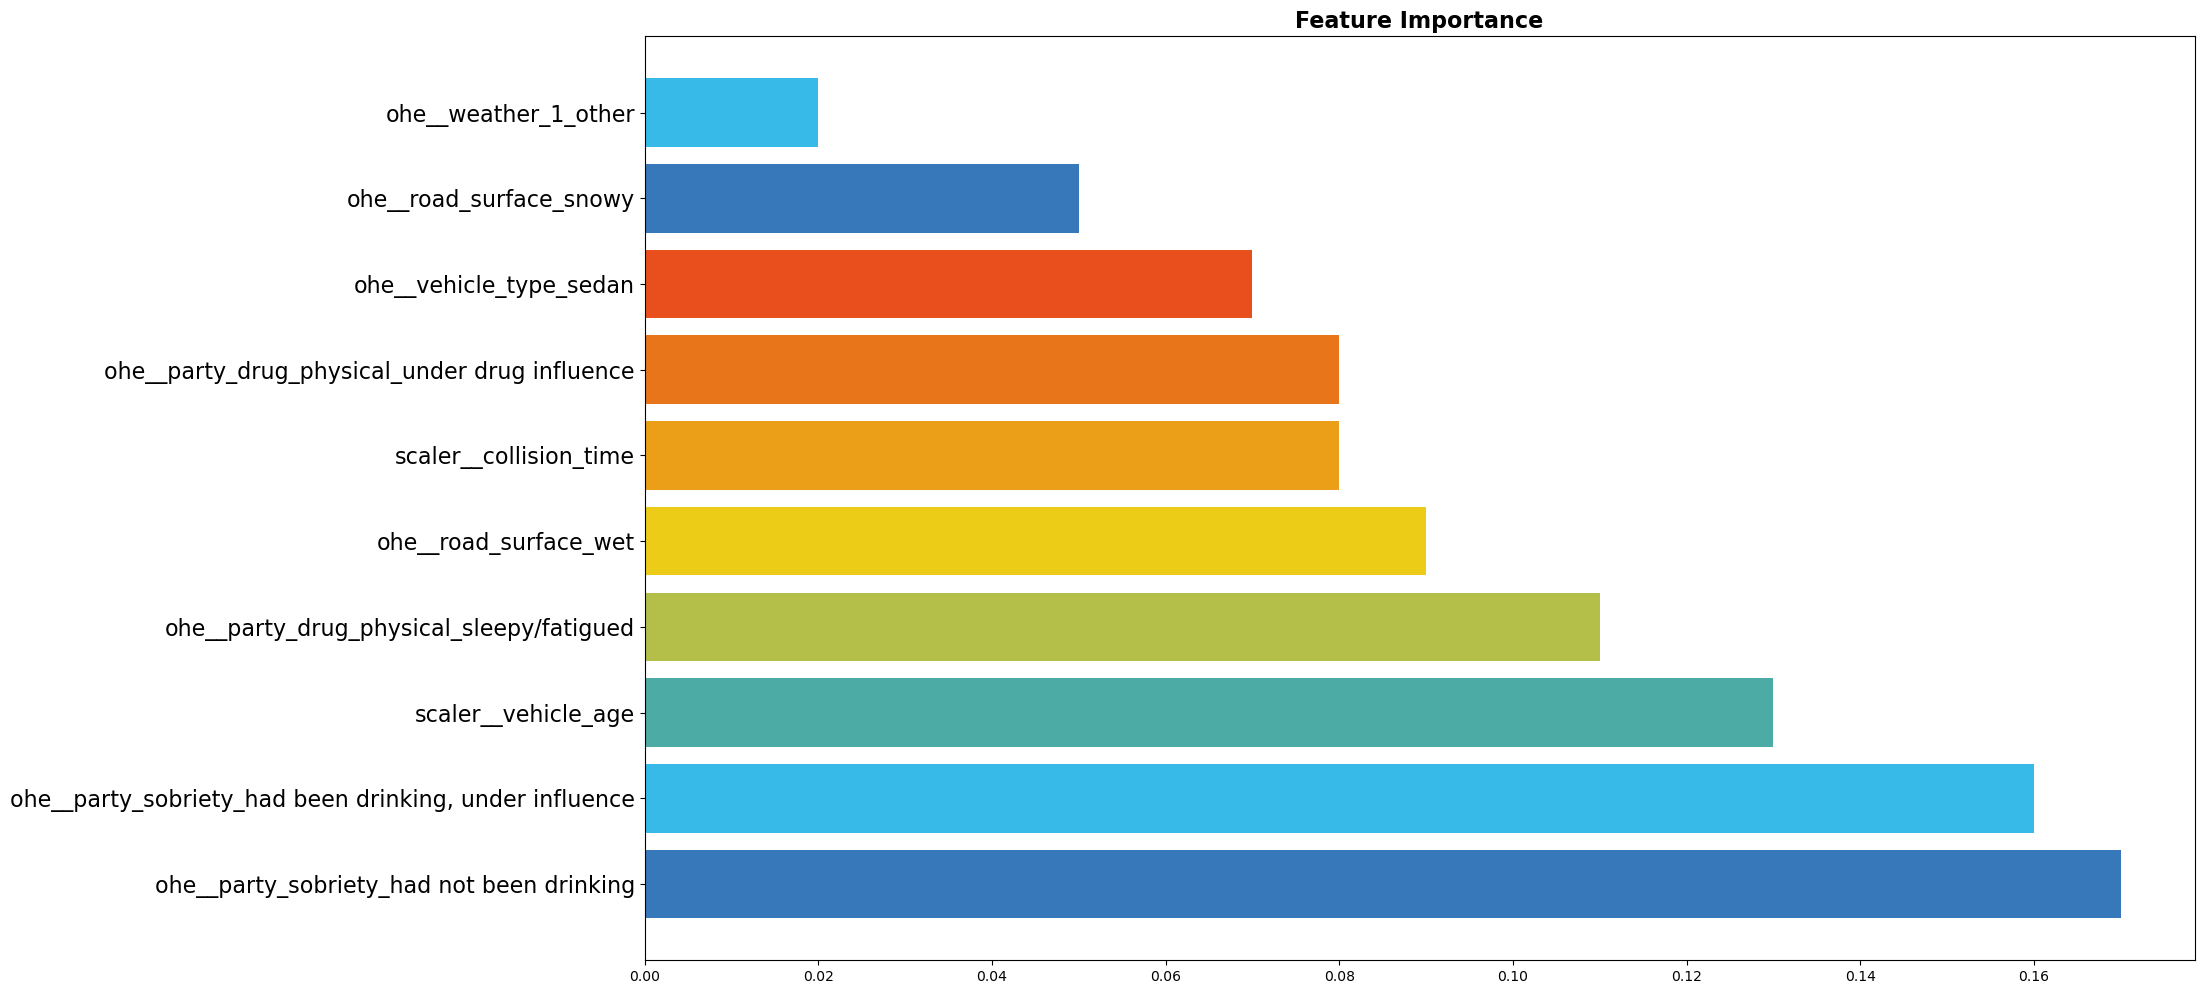

In [103]:
feature_importance = abc.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1][:10]
a = col_transformer.get_feature_names_out()

fig = plt.figure(figsize=(20, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color=my_colors)
plt.yticks(range(len(sorted_idx)), np.array(a)[sorted_idx], size=16)
plt.title('Feature Importance', size=16, weight='bold')
plt.show()

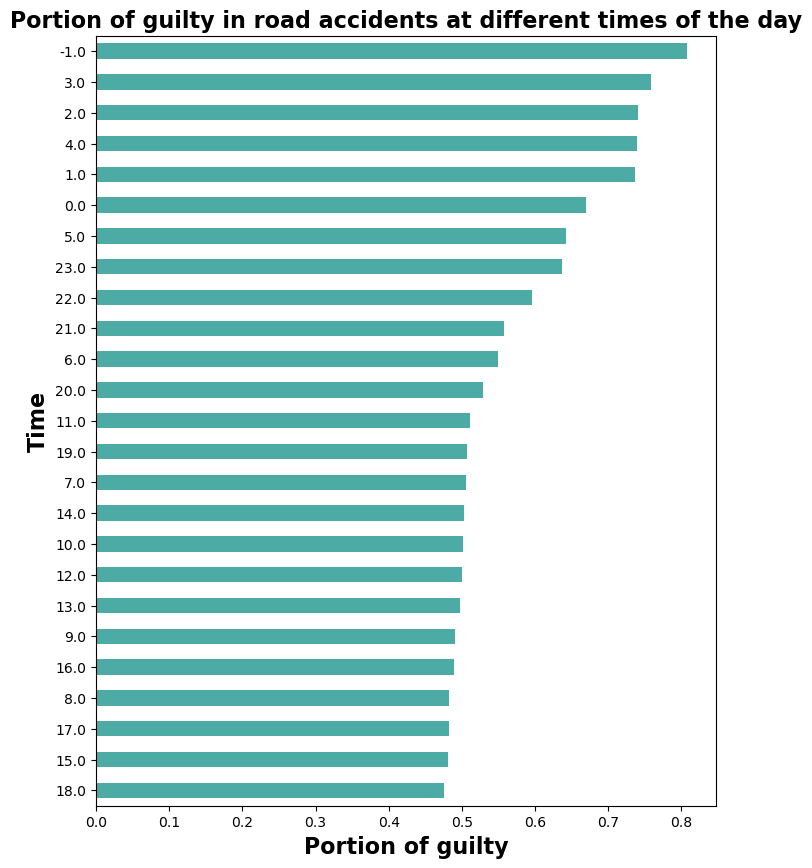

In [104]:
data.groupby('collision_time')['at_fault'].mean().sort_values().plot.barh(grid=False, color=my_colors[2], figsize=(8, 10))
plt.xlabel('Portion of guilty', size=16, weight='bold')
plt.ylabel('Time', size=16, weight='bold')
plt.title('Portion of guilty in road accidents at different times of the day', size=16, weight='bold');
plt.show()

The largest number of guilty in the accident occurs at night (from 23 to 5)

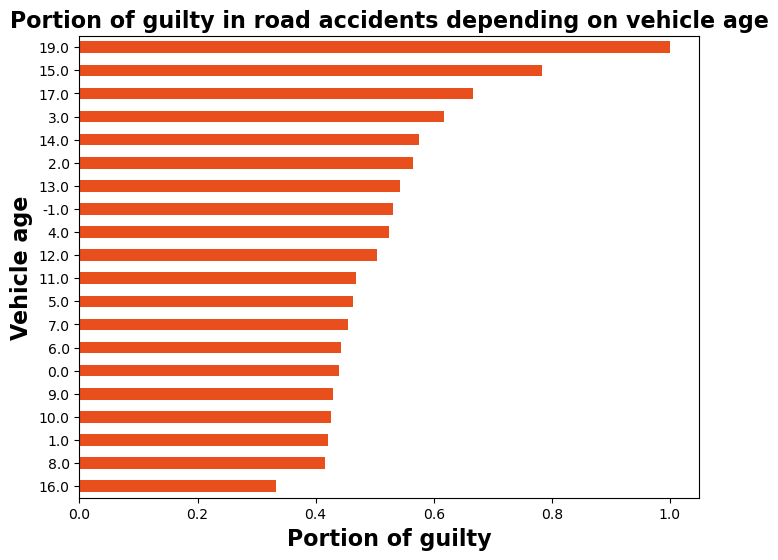

In [105]:
data.groupby('vehicle_age')['at_fault'].mean().sort_values().plot.barh(grid=False, color=my_colors[-1], figsize=(8, 6))
plt.xlabel('Portion of guilty', size=16, weight='bold')
plt.ylabel('Vehicle age', size=16, weight='bold')
plt.title('Portion of guilty in road accidents depending on vehicle age', size=16, weight='bold')
plt.show()

Drivers with old cars (over 15 years old) are more often guilty of accidents.

## Conclusions

- A model has been built to predict whether a driver will be at fault in an accident based on driver condition, weather conditions, road conditions and lighting conditions.
- AdaBoost Classifier model was used with F1 Score 0.54 Precision 0.73 Recall 0.43. The most significant features are: the travel time, the age of the car and the sobriety of the driver.
- This is an unsatisfactory result for running the model in production. To improve the model, it would be useful to add more information about the driver: age, driving experience, whether there have already been accidents.
- In addition, it would be interesting to look at a model that predicts the probability of an accident in general based on environmental conditions in order to give the driver recommendations for building a route.
- In order to reduce the risk of an accident associated with the level of sobriety, it is possible to equip the car with an alcohol intoxication analyzer. To make the measurement of the state during landing a mandatory condition for admission behind the wheel. And to make sure that it is the driver who breathes into the tube, add a camera aimed at the driver's seat.
- The risk associated with driving at night from 23 - 4, when most drivers are at fault in an accident, is probably determined by the driver's physical fatigue or road lighting. You can remind customers in the application during the journey that if they do not feel cheerful enough, then it is better to use a taxi service. You can also build a route to a point on more illuminated roads, and when turning off the route, warn about poor lighting on another road.
- Perhaps it would be advisable to invest in updating the fleet and remove cars older than 10-15 years from circulation